# **深度学习笔记**

In [ ]:
import torch
from torch import functional as F
from torch import nn
import math
print(torch.__version__)

1.10.0+cu113


## **通用技巧**

### **张量**

**torch.Tensor**用于创建Pytorch的张量对象，默认使用torch.FloatTensor作为数据类型<br>
也可以使用 **torch.tensor()** 函数创建张量
```python
x=torch.Tensor([1,2,3])
x=torch.tensor(np.array([1,2,3]))
```
Tensor对象有许多重要属性:
- **shape**：获取张量形状
- **dtype**：张量数据类型
- **device**：张量所在的设备，可以通过Tensor.to(device)操作管理

Tensor支持自动求导，通过设置**requires_grad=Ture**，可以追踪张量的操作并计算梯度
```python
x = torch.Tensor([1, 2, 3], requires_grad=True)
y = x * 2
y.backward(torch.Tensor([1, 1, 1]))  # 计算梯度
print(x.grad)  # 输出: tensor([2., 2., 2.])
```

### **广播机制**

需要满足以下条件之一:
- 两个维度大小相等
- 其中一个维度大小为1
- 其中一个张量缺少某个维度

Example:<br>
A.shape=(3,1),B.shape=(1,3)-->均被扩展为(3,3),然后逐元素操作

A.shape=(2,4),B.shape=(1,4,2)-->均被扩展为(1,4,4)

### **模型对象**

**nn.Module**

**paraneters()/name_parameters()** 获取所有可训练参数(weights & biases) 返回一个生成器 后者会多返回一个参数名称name，是一个可迭代对象

**state_dict()/load_state_dict()** 用于保存和加载模型参数<br>
也可以直接使用save() 和 load()保存加载整个模型
```python
torch.save(model.state_dict(), 'model.pth') # 保存模型
model.load_state_dict(torch.load('model.pth')) # 加载模型
```

**model.train()/eval()** 训练或评估模式 eval会关闭dropout和batchnorm的随机性 **model.training**可查看当前模式

**model.zero_grad()** 清空所有参数梯度 在optimizer().step前调用

**model.apply(func)** 对所有子层递归func 一般用来参数初始化

**model.children()** 返回所有子层,可以用list转换方便查看

**model.weight.detach()** 复制权重的值，创建一个和权重相同形状的张量，但是设置requires_grad=False detach()方法可以用在推理过程

### **参数初始化**

**torch.nn.init.xavier_normal_: Xavier正态分布初始化**,适用于激活函数为tanh或sigmoid的层。<br>

**torch.nn.init.normal_: 正态分布初始化**,可以用于一般的权重初始化,需根据经验调整均值和标准差。<br>

**torch.nn.init.kaiming_normal_: Kaiming正态分布初始化**,适用于激活函数为ReLU的层。<br>

**torch.nn.init.uniform_: 均匀分布初始化**,可以作为备选的初始化方法。<br>

**torch.nn.init.constant_: 常数初始化**,通常用于初始化偏置项,或者某些需要固定值的权重。

In [2]:
import torch.nn.init as init

linear_layer = nn.Linear(10, 20)
# 初始化权重
init.kaiming_normal_(linear_layer.weight)
# 初始化偏置
init.constant_(linear_layer.bias,0.3)

Parameter containing:
tensor([0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
        0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
        0.3000, 0.3000], requires_grad=True)

### **数据**

**torch.utils.data**

**DataLoader(dataset,batch_size,shuffle,num_workers,collate_fn,pin_memory)**<br> 
params:dataset:数据集对象 batch_size:每个批次样本数量 shuffle:是否打乱数据顺序<br>
num_workers:读取数据线程数(一般设置为CPU核心数或一半)<br>
 pin_memory设置为True会复制张量到CUDA内存，加快CPU GPU数据传输速度<br>
collate_fn:允许自定义如何将Dataset中获取的单个数据样本聚合为一个批次，当Dataset的__getitem__返回的数据具有可变长度或包含不能被默认批处理机制直接堆叠的复杂数据结构(比如Python列表和非数值类型)就需要自定义collate_fn，将复杂数据包装为字典的collate_fn是一种常用技巧

**Dataset** 数据集类 继承自torch.utils.data.Dataset 需要重写__len__和__getitem__方法 定义自己的数据集

### **激活函数**

**torch.nn**

**ReLU=max(0,x)**:默认选择,适用于绝大多数神经网络的隐藏层,但有输入为负导致梯度为0,神经元死亡的缺点

**GELU=$x \cdot \Phi(x)$**:适用于Transformer类模型

**Tanh**= $\frac{e^x - e^{-x}}{e^x + e^{-x}}$ 输出范围[-1,1],零中心输出,主要用于RNN和其变体中

**Sigmoid**= $\frac{1}{1+e^{-x}}$ 输出范围[0,1],主要用于二分类任务

**Softmax**=$\frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}$ 用于多分类任务,将输入的每个元素转换为0到1之间的概率值,并确保所有概率值之和为1



### **优化器**

**torch.optim**

(均具有decay,params,lr参数,Adam后略)<br>
过拟合风险高/参数规模大/数据量小/激活函数敏感时启用正则化 取值1e-4到1e-2

**Adam**: 使用频率最高,自适应学习率,收敛快,对超参数不敏感,适应绝大多数任务<br>
 Adam(model.parameters(),lr,betas=(beta1,beta2),eps,weight_decay,amsgrad) beta1 & beta2分别平滑梯度和调整学习率 amsgrad:要更稳定训练的复杂任务

**SGD**:精细调优任务 配合动量和学习率调度器使用,性能可以比Adam更好<br>
SGD(params,lr,momentum,dampening,decay,nesterov) dampening:动量阻尼因子,配合动量使用 nesterov:更稳定收敛场景

AdamW:适用于需要更稳定权重衰减场景(Transformer等) 参数同Adam

优化器允许用参数组传入字典列表,为不同参数组指定独立的超参数
```python
trainer = torch.optim.SGD([
    {'params': params_1x, 'lr': 0.001},
    {'params': fc_params, 'lr': 0.01}
])
```
param_groups属性返回一个包含所有参数组的列表,每个参数组都是一个字典,字典中包含了该参数组的所有超参数
```python
for param_group in optimizer.param_groups:
    print(param_group['lr'])
```

### **损失函数**

对损失函数的对象输入的约定: 第一个参数是模型的预测，第二个输入是真实的标签。

**nn.MSELoss 均方误差损失** 用于自回归,计算预测值和目标值间的均方误差, <br>
params: reduction='none'/'sum'/'mean'(默认) 不进行汇总,返回每个样本损失,返回所有样本平均损失,返回所有样本损失总和 接受数据类型为float

**nn.CrossEntropyLoss 交叉熵损失** 用于多分类,计算预测值和目标值间的交叉熵损失, input期望形状通常是(N,C),N为总共有多少个独立的分类任务，C是可能的类别数量，target为N，N必须与input的N值相等，代表样本的数量<br>
参数reduction同上 weight为每个类表指定权重处理类别不平衡 ignore_index指定一个类别索引,忽略该类别损失值<br>  loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]), reduction='mean')

**nn.BCELoss 二元交叉熵损失** 二分类任务,参数同上,无ignore_index

**nn.BCEWithLogitsLoss 二元交叉熵损失** 二分类任务,适用于未经过sigmoid处理的预测值。比先用sigmoid再用BECLoss效果要好 参数reduction同上,pos_weight为正样本权重,处理正负样本不平衡问题

**nn.KLDivLoss KL散度损失函数** 用于衡量两个概率分布之间的差异的损失函数,可以理解为两个概率分布间的距离，主要用于需要比较两个概率分布差异的场景，适于蒸馏或需要对齐分布的任务，输入应当是对数空间的预测值，目标应当是概率空间的真实值<br>
params: reduction, log_target(输入是否已取过对数)

### **批量归一化层和暂退法**

Batch Normalization 对每一层输入标准化为均值0,方差1,利于加速训练并提升模型稳定性<br>
**nn.BatchNorm(input_feature,eps=1e-5,momentum=0.1,affine=True)** 批量规范化层<br>
params:输入特征数量 稳定数值小常数(添加到方差) 动量 是否学习缩放和偏移参数

**nn.LayerNorm(input_feature)** 层规范化<br>
规范化是一种数据预处理技术，将数据转换为具有标准属性的格式(如均值0方差1),用以提高训练稳定性，加速收敛和提高泛化能力
- 批量规范化是对一个批次的每个特征维度做规范化,即基于batch内所有样本的同一个神经元上的数据做规范化
- 层规范化是对每个样本的所有特征维度做规范化,即基于batch内整个层的数据做规范化

Dropout 训练过程中随即丢弃一部分神经元防止过拟合<br>
**nn.Dropout(p=0.5)**<br>
params:丢弃概率 丢弃概率为0.5表示随机丢弃50%的神经元

```python
# 定义一个 BatchNorm1d 层,输入特征为 5
batch_norm = nn.BatchNorm1d(5)
# 定义一个 Dropout 层,丢弃概率为 0.5
dropout = nn.Dropout(p=0.5)
input_tensor = torch.randn(3, 5)
output_tensor = batch_norm(input_tensor)
output_tensor = dropout(input_tensor)
```

### **学习率调度器Scheduler**

与优化器不同，大部分调度器是在每个epoch后执行step()

**预热调度器适用于模型训练初期,参数通常时随机初始化的,直接使用较大学习率会出现训练不稳定,预热调度器通过在训练初期逐步增加学习率,帮助模型更稳定地收敛 当模型在训练初期需要逐步适应数据时或当使用较大的初始学习率可能导致训练不稳定时,都适宜使用该方法**

PyTorch 本身没有直接提供预热调度器,但可以通过组合 LambdaLR 和 StepLR 等调度器来实现预热功能。

每轮训练时,step参数更新后传入scheduler,根据step计算出比例因子,LambdaLR会将优化器中设置的LR与lr_lambda返回的比例因子相乘,预热阶段结束后达到预设的最高学习率

In [3]:
from torch.optim.lr_scheduler import LambdaLR
import torch
from torch import nn

def warmup_scheduler(optimizer, warmup_steps, base_lr):
    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return 1.0
    # LambdaLR允许通过自定义的lambda函数动态调整学习率
    return LambdaLR(optimizer, lr_lambda)

model=nn.Sequential(
    nn.Linear(10,8)
)

# 使用示例
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = warmup_scheduler(optimizer, warmup_steps=100, base_lr=0.1)

**多因子调度器在指定的 epoch 处将学习率乘以一个因子,从而在训练的不同阶段调整学习率;在迁移学习中,通常会在预训练模型的基础上进行微调。多因子调度器可以在微调过程中逐步降低学习率,以适应新的任务。当训练任务需要分阶段进行时或需要根据模型性能动态调整学习率时,该方法都很适用**

In [4]:
from torch.optim.lr_scheduler import MultiStepLR

# 使用示例
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# milestone:学习率调整的步骤 gamma:衰减因子
scheduler = MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)

**余弦调度器通常用于在训练过程中平滑地降低学习率,在训练初期保持较高的学习率,然后在训练后期逐步降低学习率。当训练任务需要平滑地调整学习率或当训练任务需要长时间进行时该方法很适合**

In [5]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# 使用示例
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# T_max:学习率从最大降到最小所需要的步骤 eta_min:学习率的最小值 学习率会在余弦周期内降到eta_min最后再回升到初始学习率
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=0.01)

**ReduceLROnPlateau(optimizer,mode='min'/'max',factor=0.1, patience=10,verbose=True)**：<br>
常用的且鲁棒性较高的学习率调度器<br>
当某个监控指标（通常是验证损失 val_loss）在一定patience个epochs内没有改善时，将学习率乘以factor verbose开启后会报告改变lr值 

**OneCycleLR(optimizer,max_lr,epochs,steps_per_epoch,pct_start,div_factor,final_div_factor)** 实现了"超级收敛"的学习率调度策略，包含三个阶段：预热、退火和冷却<br>
params: 最大学习率 总epochs数 每个epoch的优化器step的步数(一般取len(loader)) 预热阶段占训练步数的比例(一般为0.1-0.5)<br>
初始学习率 initial_lr = max_lr / div_factor（一般取25）<br>
最终学习率 final_lr = max_lr / final_div_factor（一般取1000）

### **多GPU训练**

**torch.device**是Pytorch中表示计算设备的类，用于指定张量和模型在CPU还是GPU上运行
```python
device=torch.device('cpu') # 使用CPU
device=troch.device('cuda:0') # 使用第n个GPU 
```
可以使用device.type以及device.index检查设备类型和第几个GPU

**torch.cuda.is_available()** 检查是否可用GPU是否可用

**cuda.devices_count()** 计算GPU数量

**nn.parallel.scatter(data,device)** 将数据拆分到指定的设备(GPU)上

**nn.DataParallel(model,device_ids=devices)** 用于在多GPU上执行前向后传播,该对象返回的还是一个模型对象,但是可以在多个GPU上执行操作

**torch.device(f"cuda{i}")** 返回对应编号的GPU对象

标准流程:
- model=nn.DataParallel(model)
- model.to(devices[0]) # devices是所有GPU对象的列表,这是指定一个主GPU
- 训练时,对于Dataloader中的数据,需要to(devices[0])
- 主GPU的作用是切分数据为子批次,分发到其他GPU,每次参数更新后由主GPU同步到其他GPU

### **迁移学习**

**微调 fine-tuning**:

1. 在源数据集上预训练神经网络模型,即*源模型*。
1. 创建一个新的神经网络模型,即*目标模型*。这将复制源模型上的所有模型设计及其参数（输出层除外）。
1. 向目标模型添加输出层,其输出数是目标数据集中的类别数。然后随机初始化该层的模型参数。
1. 在目标数据集上训练目标模型。输出层将从头开始进行训练,而所有其他层的参数将根据源模型的参数进行微调。

### **超参数优化**

In [6]:
import optuna
print(optuna.__version__)

4.3.0


深度学习模型除了大量训练参数（权重）外，还有许多需要用户配置的超参数。 例如：
- 学习率和批量大小 影响随机梯度下降的收敛。
- 正则化参数 (如权重衰减和Dropout) 防止过拟合。
- 网络结构参数 (如层数、每层的单元/卷积核数量) 决定模型容量和归纳偏置。
- **不能仅通过最小化训练损失来调整超参数**。这会导致在训练数据上过拟合。例如，将正则化参数设为零会降低训练损失，但可能损害泛化性能。

而手动调参费时费力，不同架构和数据集又要重新优化超参数，因此超参数优化技术(HPO)应运而生

进行超参数优化需要定义两件事：目标函数和配置空间

#### **目标函数**
- 机器学习算法的性能可以看作一个函数 $f$，它将超参数空间 $\mathcal{X}$ 中的超参数组合 $\mathbf{x}$ 映射到验证损失（实数 $\mathbb{R}$）。
    - 每次评估 $f(\mathbf{x})$ 都需要训练和验证模型，这对于大型数据集上的深度神经网络来说可能非常耗时和计算密集。
    - 我们的目标是找到使 $f(\mathbf{x})$ 最小化的超参数组合 $\mathbf{x}_{\star}$。

但实践中无法简单计算梯度，需要整个训练过程反向传播梯度，以及计算成本高和观测存在噪声等挑战。由于这些挑战，通常我们试图快速找到一组性能良好的超参数组合，而不是精确地找到全局最优解。然而，即使这样，也可能需要几天或几周的计算时间

#### **配置空间**
- 除了目标函数 $f(\mathbf{x})$，还需要定义超参数的可行集合 $\mathbf{x} \in \mathcal{X}$，这称为配置空间或搜索空间。
- 配置空间定义了每个超参数的数据类型（如浮点数、整数、类别）、取值范围（通常有上下界）以及采样分布（如均匀分布或对数均匀分布）。
- 配置空间结构可以很复杂。 有些超参数的值可能依赖于其他超参数（例如，层的单元数量取决于总层数）。
- 配置空间的选择很重要。 HPO 算法找不到不在配置空间内的超参数。如果范围太宽，找到好配置的计算成本可能过高。

典型多层感知机的超参数配置空间示例表:<br>
| Name                | Type        |Hyperparameter Ranges           | log-scale |
| :----:              | :----:      |:------------------------------:|:---------:|
| learning rate       | float       |      $[10^{-6},10^{-1}]$       |    yes    |
| batch size          | integer     |           $[8,256]$            |    yes    |
| momentum            | float       |           $[0,0.99]$           |    no     |
| activation function | categorical | $\{\textrm{tanh}, \textrm{relu}\}$ |     -     |
| number of units     | integer     |          $[32, 1024]$          |    yes    |
| number of layers    | integer     |            $[1, 6]$            |    no     |


#### **超参数优化API结构**
为了高效实现 HPO 算法，需要一个基础的代码结构。所有 HPO 算法都需要实现两个核心决策功能：搜索（Searching）和调度（Scheduling）。

##### **搜索器**
相当于一个策略制定者，搜索器的目标是： 在有限的试验次数内，尽可能快地找到使目标函数（通常是验证误差）最优的超参数组合。主要功能是：
- 根据定义的配置空间，生成新的超参数配置。 这是搜索器的核心功能。当调度器需要启动新的试验时，它会向搜索器请求一个尚未评估过的超参数组合。
- 决定如何采样配置以找到更好的性能。 不同的搜索器采用了不同的策略来完成这个任务，这直接决定了 HPO 算法的效率和最终找到的超参数配置的质量。

主要的**搜索策略**:<br>
- **随机搜索**: 它不依赖于之前试验的结果，每次都在配置空间中完全独立地随机采样一个配置。
- **网格搜索**: 在每个超参数的取值范围内，预先定义一组离散的取值点，然后遍历所有可能的超参数组合
- **基于模型的优化**: 这是一类更高级的搜索器。它们维护一个关于目标函数（验证误差）的概率模型（例如高斯过程）。这个模型会根据已经评估过的超参数配置及其性能来不断更新，以预测哪些未评估的区域可能具有较低的误差。然后，搜索器会使用一个采集函数 (Acquisition Function)（例如期望提升 Expected Improvement, 上置信界 Upper Confidence Bound 等）来决定下一个最值得探索的超参数配置。
- **基于梯度的优化**: 尝试计算目标函数关于超参数的近似梯度，然后使用梯度下降等方法沿着梯度方向更新超参数。

对除了随机搜索外的大多数高级搜索器，特别是基于模型的搜索器，update()方法至关重要,当调度器完成一个试验并返回结果时，它会调用搜索器的 update() 方法，将刚刚评估的超参数配置及其性能传递给搜索器。搜索器会利用这些新的信息来更新其内部状态或模型，从而在下次调用 sample_configuration() 时，能够生成一个基于当前最优知识（利用历史信息）且更有可能找到更好结果的新配置。

##### **调度器**
对于每个超参数配置，HPO 算法需要调度其评估过程，并决定分配多少资源。一旦开始评估某个配置，就称之为一个试验（Trial）。

调度器可以当成一个任务管理器：
- 决定何时启动新的“试验”（Trial）。 “试验”就是指用一组特定的超参数配置来训练和验证一个机器学习模型。调度器会根据当前的资源情况（比如有多少计算资源空闲）、已经进行的试验数量、以及 HPO 算法的需求来决定是否要开始一个新的试验
- 管理试验的生命周期。 调度器负责启动、监控和结束试验。在更高级的 HPO 算法中，调度器甚至可以根据试验的中间表现来决定是否提前停止某个试验（例如，如果一个试验在训练初期就表现得很差，调度器可能会决定停止它，节省资源去评估其他更有潜力的配置）
- 与搜索器交互获取配置。 当需要启动新试验时，调度器会向搜索器请求一组新的超参数配置。
- 接收试验结果并更新自身状态。 当一个试验完成后，调度器会接收到其结果（通常是验证误差）。这些结果可能会用来更新调度器内部的状态，比如记录哪些配置表现好，哪些不好

##### **调优器**
调优器是整个 HPO 过程的总指挥或协调者。它是一个更高层次的组件，负责将搜索器和调度器结合起来，驱动整个 HPO 流程的运行。它的主要职责是
- 初始化 HPO 过程。 创建搜索器和调度器实例，设置总的优化目标（比如最多运行多少个试验，或者总的计算预算）
- 驱动 HPO 循环。 在整个优化过程中，调优器会不断重复下述过程：
  - 向调度器查询是否有资源可以启动新试验。
  - 如果可以，调度器会向搜索器请求新配置，然后启动试验。
  - 接收调度器完成的试验结果。
  - 记录所有试验的结果。
  - 追踪并更新当前找到的最佳超参数配置及其对应的性能。
- 提供 HPO 过程的接口。 用户通过调优器来启动、暂停、监控 HPO 过程，并获取最终的最佳结果。
- 记录所有试验的配置、结果、运行时间等信息，并在过程结束后报告最佳结果和整个优化过程的统计信息。

#### **多保真HPO**
核心思想：训练一个神经网络配置（一套超参数）很花时间，而 HPO 需要评估很多配置。我们希望能更快地找到好的配置，而不是每个都完整训练一遍。

我们关注的目标函数是$f(x,r)$，代表用超参数配置$x$训练，并花费资源量$r$时的表现（通常为验证误差）,$r$可以是epochs数、第1000个数据点等
- 假设表现$f(x,r)$会随资源$r$增加而变好（误差降低）
- 计算成本$c(x,r)$会随资源$r$增加而增加
多保真HPO的目的就是在给定总预算下最大化找到最优超参数配置的概率

##### **逐次减半机制**
假设有多个不同资源等级，如10、50、100个epochs
- epochs==10：随机选择很多个（比如 N 个）超参数配置。每个都只训练 10 个 epoch。
  - 看看这 N 个配置训练 10 个 epoch 后的表现（比如验证误差）。把表现最差的比如 70% 淘汰掉。
- epochs==50：剩下表现最好的 30% 配置。把这些配置的训练继续到 50 个 epoch。
  -  看看这剩余配置训练 50 个 epoch 后的表现，再把表现最差的一部分淘汰掉。
- epochs==100： 只剩下表现最好的少数配置。把这些配置的训练继续到 100 个 epoch。
  - 从最后这些完成最高资源训练的配置中，选出最好的。

 从一个资源等级跳到下一个资源等级时，幸存试验需要花费的资源量会乘以 reduction_factor,用$\eta$表示,比如第二轮trial的最低资源量是2倍$r_{min}$

在每个资源等级完成评估后，表现最好的试验的数量会是当前等级试验数量的$\frac{1}{\eta}$
##### **异步逐次减半(ASHA)**
核心问题： 标准的逐次减半（SH）在一个并行计算环境中运行起来效率不高，因为它要求在每个“资源等级”（比如所有配置都训练到 10 个 epoch 后）进行同步。必须等这一批所有配置都跑完这个等级的资源，才能根据表现进行淘汰，然后把幸存者推到下一个等级。

**ASHA**:当某个“资源等级”收集到的评估结果数量达到一定阈值(比如$\eta$个)，就立即对这些结果进行评估和淘汰，并把其中表现最好的立即推到下一个资源等级，无需等待同等级的其他所有配置完成。<br>
如果有工作者(能够独立地评估一个超参数配置的计算资源)空闲，并且没有配置可以从当前等级被提升到下一等级，那么就立即启动一个新的配置，从最低资源等级开始评估

#### **基于Optuna的HPO**

##### **配置空间和目标函数**
```python
def objective(trial): # 自定义的目标函数，接受一个trial对象
    # 配置空间，使用trial.suggest_* 系列方法来定义
    learning_rate=trial.suggest_int('learning_rate',1e-3, 1e-1,log=True) # 变量名和范围 log表示用对数均匀分布
    # 模型训练和评估函数部分，略
    return accuracy # 性能指标，这里用准确度代替
```

##### **搜索器、调度器、调优器和多保真HPO**
调优器作为整个HPO的管理实体，被整合在**Study**对象中，该对象是Optuna的核心 **optuna.create_study()**
 
搜索器被整合在创建Study时指定的参数**sampler**中 <br>
**sampler=optuna.samplers.RandomSampler()** 随机搜索<br>
**optuna.samplers.TPESampler(seed=42)** TPE搜索

调度器和多保真HPO策略通过**optuna.pruners**剪枝器模块实现 在每轮epoch中<br>
都需要用 **trial.report(loss/accuracy(性能指标),step=epoch)** 向Optuna报告中间结果和当前已完成的资源量，并且使用should_prune()判断是否需要剪枝
```python
if trial.should_prune():
    print("提示词")
    raise optuna.exceptions.TrialPruned()
# ---
# 逐次减半剪枝器
pruner = optuna.pruners.SuccessiveHalvingPruner(
    min_resource_ratio=0.1, # 表示最低资源量为 max_epochs * 0.1
    n_warmup_steps=5, # n_warmup_steps: 在每个试验中，至少运行多少个步骤 (epochs) 才考虑剪枝。
    interval_steps=1 # interval_steps: 每隔多少个步骤检查一次是否剪枝。
)

# 中位数剪枝器
# 如果当前试验的结果显著差于中位数（例如，最小化目标时，损失大于中位数），
# 就认为这个试验没有潜力，应该被剪枝。
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=5, #  在开始的多少个试验中不进行剪枝
    n_warmup_steps=10, # 前10个epoch不剪枝
    interval_steps=5 # 每隔5个epoch检查一次
)
```

**Study**对象常用参数: <br>
**direction='minimize/maxmize'**: 最大/最小化评价因子
**pruner**: 指定剪枝器 **samplers**: 指定搜索器

开始HPO: study.optimize(objective,n_trials=num_trials) n_trials表示进行多少轮实验

检查最佳参数和结果:
```python
if study.best_trial:
        best_trial = study.best_trial
        # 最佳目标函数返回值
        print(best_trial.value)
        # 查看最佳参数
        for key, value in best_trial.params.items():
            print(f"{key}:{value}")
```
[HPO实例](./utils/hpo.py)

## **神经网络层**

**nn.Linear(in_features, out_features, bias=True)** 全连接层,线性变换输入的数据<br>
params: 输入数据(形状 batch, in_features),输出数据(形状 batch, out_features)

**nn.Flatten(input_tensor, start_dim)** 展平层,将多维张量展平为一维张量<br>
params: input_tensor: 输入张量； start_dim: 指定从哪一维开始展平,前面的维度保持不变,后续维度合并为一维张量

**nn.Embedding(num_embedding,embedding_dim)** 嵌入层,将num_embedding大小的词表转换为特征向量,embedding_dim是生成的词向量的列数<br>
params: num_embedding告诉 Embedding 层它需要准备一个多大的查找表（一个矩阵），这个表里有多少行向量,值取决于这个 Embedding 层被设计用来处理的、所有可能的、输入 ID 的总数量,是 Embedding 层能够处理的 ID 范围的最大值 + 1<br>
embedding_dim决定了分配后的数据的维度，输出张量形状变化: 如 (batch,seq_len) -> (batch,seq_len,embed_size)

**神经层、激活函数层、BN层和Dropout层顺序**

常设计为:神经层->BN层->激活函数层->Dropout层

### **CNN**

**平移不变性**:无论目标在图像中的位置如何变化,CNN都能识别出该目标。处理图像时具有鲁棒性,能够识别出不同位置的相同特征

#### **卷积层**

**卷积核**是一个小的矩阵,用于在输入图像上滑动并执行卷积操作,从而提取特征。卷积操作可以看作是对输入图像的局部区域进行加权求和。每次滑动时,卷积核与输入图像的对应区域进行逐元素相乘并求和,生成特征图中的一个像素。

**步长**决定了卷积核在图像上滑动的步幅,步长越大,输出特征图大小越小

**填充**在输入图像边缘添加额外像素,通常是为了控制输出特征图大小
- 零填充 (Zero Padding): 在输入图像的边缘添加值为 0 的像素
- 有效填充 (Valid Padding): 不进行填充,输出特征图的大小会减小
- 相同填充 (Same Padding): 填充使得输出特征图的大小与输入图像相同

**nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,bias=True)**<br>
params: 输入图像的通道数 卷积核的数量,即输出特征图的通道数<br> 卷积核的大小,可以是单个数字(如3)或元组(如(3,3))<br> 卷积核移动的步长 填充的大小 是否添加偏置项<br>
其中padding=0为有效填充 padding=1为0填充 padding='same'使输出特征图大小等同输入图像

#### **池化层**
Pooling Layer 用于降低特征图的空间维度,通常使用最大池化或平均池化。 池化操作在特征图上滑动,每次滑动时取池化核覆盖区域的最大值或平均值<br>

**nn.MaxPool2d(kernel_size, stride)**: 提取最显著的特征,减少特征图的空间维度,从而减少模型的参数数量,降低过拟合的风险。一般在图像分类任务中降低特征图空间维度

**nn.AvgPool2d(kernel_size, stride)**：用于平滑特征图,适合在需要保留整体特征信息时使用。全局平均池化中,平均池化层将整个特征图池化为一个值,常用于全连接层之前,以减少参数数量。在图像分割任务中,平均池化可以用于保留更多的上下文信息

#### **感受野**

指的是神经网络中某特定神经元在输入图像上所能看到的区域大小,即神经元输出值受图像上哪些区域的影响。
- 卷积核大小决定了感受野,如$3*3的卷积核感受野就是3*3$ 
- 池化层会扩大感受野,如一个2*2的最大池化层,步长为2,会将感受野扩大2倍
- 计算方法:从输出层开始向前计算
  - 对卷积层来说$RF_{l} = RF_{l+1} + (k - 1) * s$ 
  - 对于池化层$RF_{l} = RF_{l+1} * s$
  - $RF表示第i层感受野,k是卷积核大小,s是步长$

#### **输出特征图大小**

$ W/H_{out} = \lfloor \frac{W/H_{in} - k + 2p}{s} \rfloor + 1$

其中W/H表示图像的宽高,k是卷积核大小,p是padding大小,s是步长
 
#### **$1 \times 1$卷积核**

- 当输入和输出通道数不一致可以将通道数调整一致
- 深层resnet中 每个残差块设计为($1*1->3*3->1*1$) 通过两个1*1卷积块达到降维再升维,减少3*3块计算量
- 调整stride值能降低图像尺寸

#### **VGG**

全部使用3x3卷积核,步幅为1,填充为1,池化层使用2x2最大池化,步幅为2,通过堆叠多个卷积层和池化层来构建深度网络,实现与大核卷积相似的感受野,同时减少参数数量

#### **Inception**

通过并行使用不同大小的卷积核（如 1x1、3x3、5x5）和池化层,提取多尺度特征。可以捕捉不同尺度的特征,提高模型的表达能力

#### **ResNet**

$H(x)=F(x)+x$ 跳跃连接,将输入$X$加到输出上,若$F(x)=0$,则$H(x)=x$,即恒等映射,$H(x)$和$x$的形状相同,缓解了梯度消失问题,避免性能退化

In [7]:
class Residual(nn.Module): 
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    def forward(self, X):
        Y=F.relu(self.bn1(self.conv1(X)))
        Y=self.conv2(Y)
        Y=self.bn2(Y)
        if self.conv3: # 若需要调整通道或尺寸
            X=self.conv3(X)
        Y+=X
        return F.relu(Y)

### **RNN**

循环神经网络（RNN）是一种专门用于处理序列数据的神经网络,它能够捕捉序列中的时间依赖关系,并利用先前的信息来影响当前的输出。RNN 的结构包括一个隐藏状态,该状态在每个时间步中更新,并用于计算当前时间步的输出。RNN 在每个时间步接收当前输入和上一个时间步的隐藏状态,输出当前时间步的隐藏状态和输出

$h_t = \sigma(W_h h_{t-1} + W_x x_t + b_h)$

$y_t = W_y h_t + b_y$

其中$h_t$是隐藏状态,$x_t$是输入,$y_t$是输出,$\sigma$是激活函数,$W_h$是隐藏状态权重,$W_x$是输入权重,$b_h$是隐藏状态偏置,$W_y$是输出权重,$b_y$是输出偏置

**nn.RNN(input_size,hidden_size,num_layers,nonlinearity,dropout,bidirectional,batch_first)**<br>
params: 输入特征量 隐藏层大小 RNN层数=1 使用非线性激活函数='tanh' 若num_layer>1就在最后一层外的每一层应用dropout<br> 
是否使用双向RNN=False 默认输出形状为(seq_len, batch_size, input_size),True后为(batch_size, seq_len, input_size)

**nn.LSTM** & **nn.GRU** 同上

In [8]:
class SimpleRNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.rnn=nn.RNN(input_size,hidden_size,batch_first=True)
        self.fc=nn.Linear(hidden_size,output_size)
    def forward(self,x):
        x,h_n=self.rnn(x)
        x=self.fc(x)
        return x,h_n

#### **LSTM**

Long Short-Term Memory(LSTM) 是一种特殊的 RNN,它能够更好地处理长期依赖关系,并能够防止梯度消失问题。LSTM 的结构包括一个记忆单元,该单元在每个时间步中更新,并用于计算当前时间步的输出。

LSTM引入门控机制,包含*输入门,遗忘门和输出门*来控制信息的流动,从而有效地捕捉长距离依赖关系<br>
相应地,时间步$t$的门被定义如下：
输入门是$\mathbf{I}_t \in \mathbb{R}^{n \times h}$,
遗忘门是$\mathbf{F}_t \in \mathbb{R}^{n \times h}$,
输出门是$\mathbf{O}_t \in \mathbb{R}^{n \times h}$。

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}
$$

LSTM引入了一个候选记忆元,选用tanh作为激活函数
$$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c),$$

输入门$\mathbf{I}_t$控制采用多少来自$\tilde{\mathbf{C}}_t$的新数据,
而遗忘门$\mathbf{F}_t$控制保留多少过去的
记忆元$\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$的内容。
使用按元素乘法,得出：

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$
如果遗忘门始终为$1$且输入门始终为$0$,
则过去的记忆元$\mathbf{C}_{t-1}$
将随时间被保存并传递到当前时间步。
引入这种设计是为了缓解梯度消失问题,
并更好地捕获序列中的长距离依赖关系

而对于LSTM中的隐状态有:$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$

只要输出门接近$1$,我们就能够有效地将所有记忆信息传递给预测部分,
而对于输出门接近$0$,我们只保留记忆元内的所有信息,而不需要更新隐状态。

![LSTM](./resources/lstm.png)

#### **GRU**

门控循环单元(GRU)是 LSTM 的简化版本,通过引入两个门控机制（更新门和重置门）来控制信息的流动

重置门$\mathbf{R}_t \in \mathbb{R}^{n \times h}$和
更新门$\mathbf{Z}_t \in \mathbb{R}^{n \times h}$的计算如下:
$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned}
$$

候选隐状态：$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + (\mathbf{R}_t \odot \mathbf{H}_{t-1}) \mathbf{W}_{hh} + \mathbf{b}_h)$$ 

上述的计算结果只是候选隐状态,我们仍然需要结合更新门$\mathbf{Z}_t$的效果。
这一步确定新的隐状态$\mathbf{H}_t \in \mathbb{R}^{n \times h}$
在多大程度上来自旧的状态$\mathbf{H}_{t-1}$和
新的候选状态$\tilde{\mathbf{H}}_t$。
更新门$\mathbf{Z}_t$仅需要在
$\mathbf{H}_{t-1}$和$\tilde{\mathbf{H}}_t$
之间进行按元素的凸组合就可以实现这个目标。
这就得出了门控循环单元的最终更新公式：


$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1} + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t$$

每当更新门$\mathbf{Z}_t$接近$1$时,模型就倾向只保留旧状态。
此时,来自$\mathbf{X}_t$的信息基本上被忽略,
从而有效地跳过了依赖链条中的时间步$t$。
相反,当$\mathbf{Z}_t$接近$0$时,
新的隐状态$\mathbf{H}_t$就会接近候选隐状态$\tilde{\mathbf{H}}_t$。
这些设计可以帮助我们处理循环神经网络中的梯度消失问题,
并更好地捕获时间步距离很长的序列的依赖关系。

![GRU](./resources/GRU.png)

#### **梯度裁剪**

梯度裁剪(Gradient Clipping):训练 RNN 时,由于反向传播过程中梯度通过时间步（time steps）不断累积,可能会导致梯度值变得非常大,这种现象称为 梯度爆炸。梯度爆炸会导致模型参数更新过大,使得训练过程不稳定,甚至导致模型无法收敛

梯度裁剪通过限制梯度的最大值,防止梯度爆炸。具体来说,梯度裁剪会在每次更新参数之前,检查梯度的范数（norm）,如果梯度的范数超过某个阈值,就将梯度按比例缩小,使其范数不超过该阈值

数学原理:
梯度裁剪的基本思想是通过限制梯度的大小来防止梯度爆炸。以基于范数的梯度裁剪为例,设梯度为 g,其 L2 范数为
\begin{equation}
\|g\|_2 = \sqrt{\sum_i g_i^2}
\end{equation}

当 $\|g\|_2$ 超过预设的最大值 $\text{max\_norm}$ 时,将梯度按比例缩放,公式为：
\begin{equation}
\tilde{g} = g \cdot \min\left(1, \frac{\text{max\_norm}}{\|g\|_2}\right)
\end{equation}

即：如果 $\|g\|_2 \leq \text{max\_norm}$ 则 $\tilde{g} = g$；否则 $\tilde{g}$ 的范数被限制为 $\text{max\_norm}$。

对于逐值梯度裁剪,每个梯度分量 $g_i$ 被限制在区间 $[-\text{clip\_value},\, \text{clip\_value}]$ 内,其数学表达为：
\begin{equation}
\tilde{g}_i = \min\left(\max\left(g_i, -\text{clip\_value}\right),\, \text{clip\_value}\right)
\end{equation}
这种方法能够有效控制梯度数值过大,从而保证训练过程的稳定性。


**torch.nn.utils.clip_grad_norm_(parameters, max_norm, norm_type=2)**<br>
params: 需要裁剪的参数 最大范数 范数类型(默认2-L2范数)

**clip_grad_value_(parameters, clip_value)**<br>
params: 需要裁剪的参数 裁剪值

clip_grad_value_ 通过限制梯度的最大值,防止梯度爆炸。具体来说,clip_grad_value_会在每次更新参数之前,检查梯度的值,如果梯度的值超过某个阈值,就将梯度按比例缩小,使其值不超过该阈值

clip_grad_norm_ 通过限制梯度的范数,防止梯度爆炸。具体来说,clip_grad_norm_会在每次更新参数之前,检查梯度的范数,如果梯度的范数超过某个阈值,就将梯度按比例缩小,使其范数不超过该阈值


#### **编码器和解码器**

编码器负责将输入的序列转化为固定长度的上下文变量,解码器负责将上下文变量解析获得结果。编码器接受一个长度可变的序列作为输入,并将该序列转换为固定长度的上下文变量$c$,解码器负责将$c$映射为长度可变的序列,这就是编码器-解码器架构<br>
$c$实际上可以看作编码器传递下来的"状态"

In [9]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
    def forawrd(self,):
        raise NotImplementedError
    
class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
    
    def init_state(self,encoder_state):
        raise NotImplementedError
    
    def forward(self,X,state):
        raise NotImplementedError
    
class EncoderDecoder(nn.Module):
    def __init__(self,encoder,decoder) -> None:
        super().__init__()
        self.encoder=encoder
        self.decoder=decoder
    
    def forward(self,X,**kwargs):
        encoder_output=self.encoder(X)
        decoder_state=self.decoder.init_state(encoder_output)
        return self.decoder(decoder_state,X)

**数据处理**

**词元化**<br>
tokenize 词元化是将一段自然语言文本拆分为更小的单元。对文本序列词元化,每个词元要么是一个词要么是一个标点符号
```python
def tokenize(text):
    # 正则表达式匹配单词、标点符号以及常见的缩写形式
    tokens = re.findall(r"\b\w+(?:['’]\w+)?\b|[\w’]+|[\W&&[^\s]]", text)
    return tokens
```

对于单词级的词元化时,我们需要将出现频率过低的词设置为$<unk>$词元,在小序列训练时将所有序列填充到同一长度的$<pad>$填充词元,序列开始词元$<bos>$和结束词元$<eos>$

训练中,对于输入到编码器和解码器的所有词元,需要使用**nn.Embedding**编码,从离散的token转化为连续的词向量。
- 编码器的输入通常在末尾添加$<eos>$
- 解码器的输入是目标序列,需要在序列开头添加$<bos>$，且不包含最后一个token,这种设计是为了通过Teacher Forcing机制，基于前一个真实token预测下一个token
- 训练的目标序列需要在序列末尾添加$<eos>$，解码器的目标是逐步生成至$<eos>$以标志生成结束

## **Transformer**

Transformer是由编码器和解码器构成的,编码器和解码器是基于自注意力的模块叠加而成的，源（输入）序列和目标（输出）序列的嵌入（embedding）表示将加上位置编码（positional encoding），再分别输入到编码器和解码器中。

从宏观角度来看，Transformer的编码器是由多个相同的层叠加而成的，每个层都有两个子层（子层表示为$\mathrm{sublayer}$）。第一个子层是*多头自注意力*（multi-head self-attention）汇聚；第二个子层是*基于位置的前馈网络*（positionwise feed-forward network）。具体来说，在计算编码器的自注意力时，查询、键和值都来自前一个编码器层的输出。受残差网络启发，每个子层都采用了*残差连接*（residual connection）。在Transformer中，对于序列中任何位置的任何输入$\mathbf{x} \in \mathbb{R}^d$，都要求满足$\mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$，以便残差连接满足$\mathbf{x} + \mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$。在残差连接的加法计算之后，紧接着应用*层规范化*（layer normalization）因此，输入序列对应的每个位置，Transformer编码器都将输出一个d维表示向量。

Transformer解码器也是由多个相同的层叠加而成的，并且层中使用了残差连接和层规范化。除了编码器中描述的两个子层之外，解码器还在这两个子层之间插入了第三个子层，称为编码器－解码器注意力（encoder-decoder attention）层。在编码器－解码器注意力中，查询来自前一个解码器层的输出，而键和值来自整个编码器的输出。在解码器自注意力中，查询、键和值都来自上一个解码器层的输出。但是，解码器中的每个位置只能考虑该位置之前的所有位置。这种掩蔽（masked）注意力保留了自回归（auto-regressive）属性，确保预测仅依赖于已生成的输出词元。

接下来将逐一拆解这些子层

![transformer](./resources/transformer.png)

### **注意力机制**

普通注意力机制通常处理两个不同的序列,如在Encoder-Decoder架构中。注意力机制计算的是Query和Key的相关性,然后根据相关性对Value进行加权求和(Query来自一个序列,Key和Value来自另一个序列)

$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$

自注意力机制是注意力机制的一种特殊形式,Query,Key,Value都来自同一个序列,它允许模型在处理序列数据时,关注序列中的不同位置<br>
假设输入序列为$\mathbf{X} = [\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n]$ 自注意力机制计算如下:
- **计算查询 (Query)、键 (Key) 和值 (Value)**:
   $\mathbf{Q} = \mathbf{X} \mathbf{W}_Q, \quad \mathbf{K} = \mathbf{X} \mathbf{W}_K, \quad \mathbf{V} = \mathbf{X} \mathbf{W}_V$
- **计算注意力分数**:
   $\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left(\frac{\mathbf{Q} \mathbf{K}^T}{\sqrt{d_k}}\right) \mathbf{V}$

#### **注意力汇聚**

**带掩码的softmax**

实践中处理变长序列时,通常要使用掩码mask来处理无效位置(如填充位置),确保softmax只对有效位置进行计算。注意力分数是通过Query和Key计算得到的，因此不希望任何无效的Key对任何Query注意力权重产生贡献，所以掩码操作在key_seq_len维度上，确保softmax操作时无效Key对应分数变得很小

In [10]:
def masked_softmax(X, valid_len_or_mask_tensor, is_causal_scenario=False):
    if is_causal_scenario:
        # valid_len_or_mask_tensor 是预先计算好的因果掩码张量
        # True 值表示需要被掩码的位置
        causal_mask_tensor = valid_len_or_mask_tensor.to(device=X.device, dtype=torch.bool)
        X_masked = X.masked_fill(causal_mask_tensor, -1e6)
    elif valid_len_or_mask_tensor is not None:
        # 处理基于 valid_len (有效长度) 的填充掩码
        valid_lengths = valid_len_or_mask_tensor # (batch_eff,) or (batch_eff, 1)
        k_seq_len = X.shape[-1] # key 序列的长度

        if valid_lengths.dim() == 1:
            valid_lengths = valid_lengths.unsqueeze(1) # -> (batch_eff, 1)
        
        indices = torch.arange(k_seq_len, device=X.device).unsqueeze(0).unsqueeze(0) # -> (1, 1, k_seq_len)
        padding_mask = indices >= valid_lengths.unsqueeze(-1) # -> (batch_eff, 1, k_seq_len)
        
        final_padding_mask = padding_mask.expand_as(X) # -> (batch_eff, q_seq_len, k_seq_len)
        X_masked = X.masked_fill(final_padding_mask, -1e6)
    else:
        # 没有掩码 (valid_len_or_mask_tensor is None and not is_causal_scenario)
        return torch.softmax(X, dim=-1)
        
    return torch.softmax(X_masked, dim=-1)


**加性注意力**

一般来说,当查询和键是不同长度的矢量时,可以使用加性注意力作为评分函数。
给定查询$\mathbf{q} \in \mathbb{R}^q$和
键$\mathbf{k} \in \mathbb{R}^k$,
*加性注意力*（additive attention）的评分函数为

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$

In [11]:
class AdditiveAttention(nn.Module):
    def __init__(self,query_size,key_size,attn_size,dropout) -> None:
        super().__init__()
        # 禁止bias,使计算注意力分数时专注于query和key的相互作用
        self.W_q=nn.Linear(query_size,attn_size,bias=False)
        self.W_k=nn.Linear(key_size,attn_size,bias=False)
        self.W_v=nn.Linear(attn_size,1,bias=False)
        self.dropout=nn.Dropout(dropout)
    
    def forward(self,queries,keys,values,valid_len=None):
        queries,keys=self.W_q(queries),self.W_k(keys)
        # 维度扩展后queries形状是batch,查询个数,1,attn_size
        # key的形状：(batch_size,1,键数,attn_size)
        # 这样通过广播机制就会变为batch,查询个数,键数,attn_size
        features=queries.unsqueeze(2)+keys.unsqueeze(1)
        features=torch.tanh(features)
        scores=self.W_v(features).squeeze(-1)
        self.attention_weights=masked_softmax(scores,valid_len)
        return torch.bmm(self.dropout(self.attention_weights),values)

**缩放点积注意力**

使用点积可以得到计算效率更高的评分函数,
但是点积操作要求查询和键具有相同的长度$d$。
假设查询和键的所有元素都是独立的随机变量,
并且都满足零均值和单位方差,
那么两个向量的点积的均值为$0$,方差为$d$。
为确保无论向量长度如何,
点积的方差在不考虑向量长度的情况下仍然是$1$,
我们再将点积除以$\sqrt{d}$,
则*缩放点积注意力*（scaled dot-product attention）评分函数为：

$$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}.$$

- 除以$\sqrt{d}$是因为假设QK的方差为1，注意力分数的方差将为d,除以$\sqrt{d}$后，注意力分数的方差为1，从而保持梯度稳定

In [12]:
class DotProductAttention(nn.Module):
    def __init__(self,dropout) -> None:
        super().__init__()
        self.dropout=nn.Dropout(dropout)
        
    def forward(self,queries,keys,values,valid_len_or_mask_tensor=None,is_causal_scenario=False):
        d=queries.shape[-1]
        scores=torch.bmm(queries,keys.transpose(1,2))/math.sqrt(d)
        self.attention_weights=masked_softmax(scores,valid_len_or_mask_tensor,is_causal_scenario)
        return torch.bmm(self.dropout(self.attention_weights),values)



#### **多头注意力机制**

多头注意力机制的主要思想是把注意力计算拆分成多个并行的子空间,每个头都会对输入（查询、键和值）进行线性投影
- 这样可以让模型从不同的角度捕捉输入序列中的各种信息和特征
- 将高维空间分成多个低维空间进行计算,可以降低每个头中内积运算所产生的数值过大问题
- 各个注意力头计算得到的结果会被拼接（concat）起来,再经过一个线性映射输出最终结果,这样模型能汇聚来自不同子空间的多样化信息,加强整体的表达能力。

多头注意力机制的计算过程如下：<br>
假设现在有$h$个头,多头注意力机制计算过程如下:
-  **计算每个头的查询、键和值**:
   $\mathbf{Q}_i = \mathbf{X} \mathbf{W}_Q^{(i)}, \quad \mathbf{K}_i = \mathbf{X} \mathbf{W}_K^{(i)}, \quad \mathbf{V}_i = \mathbf{X} \mathbf{W}_V^{(i)}$
-  **计算每个头的注意力分数**:
   $\text{Attention}_i(\mathbf{Q}_i, \mathbf{K}_i, \mathbf{V}_i) = \text{softmax}\left(\frac{\mathbf{Q}_i \mathbf{K}_i^T}{\sqrt{d_k}}\right) \mathbf{V}_i$
-  **合并多个头的注意力分数**:
   $\text{MultiHeadAttention}(\mathbf{X}) = \text{concat}(\text{Attention}_1(\mathbf{Q}_1, \mathbf{K}_1, \mathbf{V}_1), \ldots, \text{Attention}_h(\mathbf{Q}_h, \mathbf{K}_h, \mathbf{V}_h))$





In [13]:
from utils.transformer import transpose_qkv
from utils.transformer import transpose_output

class MultiHeadAttention(nn.Module):
    def __init__(self,d_model,
                 num_heads,dropout):
        super().__init__()
        self.num_heads=num_heads
        self.attention=DotProductAttention(dropout)
        self.W_q=nn.Linear(d_model,d_model,bias=False)
        self.W_k=nn.Linear(d_model,d_model,bias=False)
        self.W_v=nn.Linear(d_model,d_model,bias=False)
        self.W_o=nn.Linear(d_model,d_model,bias=False)
    
    def forward(self,queries,keys,values,valid_len=None,is_causal_scenario=False):
        q_trans = transpose_qkv(self.W_q(queries), self.num_heads)
        k_trans = transpose_qkv(self.W_k(keys), self.num_heads)
        v_trans = transpose_qkv(self.W_v(values), self.num_heads)
        
        # 根据是因果场景还是填充场景来处理 valid_len 或 mask_tensor
        # is_causal_scenario=True: valid_len 就是预计算的因果掩码张量, 无需repeat
        # is_causal_scenario=False: valid_len 是长度张量, 需要为多头repeat
        if not is_causal_scenario and valid_len is not None:
            # 这是处理填充掩码的情况，valid_len 是长度张量
            processed_mask_input = torch.repeat_interleave(valid_len, self.num_heads, dim=0)
        else:
            # 这是因果掩码情况 (valid_len 是 causal_mask_tensor) 或 valid_len is None
            processed_mask_input = valid_len

        attention_output = self.attention(q_trans, k_trans, v_trans, processed_mask_input, is_causal_scenario)
        output=transpose_output(attention_output,self.num_heads)
        return self.W_o(output)

### **位置编码**

因为自注意力机制本身和位置无关,通过计算序列中每个元素和其他元素的相关性捕捉依赖关系,但是无法感知位置信息。但NLP等任务中序列的顺序信息对理解语义很重要,所以引入位置编码为模型提供位置信息

  $$\begin{aligned} p_{pos, 2i} &= \sin\left(\frac{pos}{10000^{2i/d}}\right),\\p_{pos, 2i+1} &= \cos\left(\frac{pos}{10000^{2i+1/d}}\right).\end{aligned}$$
其中$pos$是元素在序列中的位置,$i$是词向量的维度。

**设计特点**
- 周期性的三角函数可以自然表示位置信息,不会随位置值增加而无限增长(若直接使用位置索引),周期性可以让模型捕捉相对位置信息(整数编码无法捕捉相对信息),通过正余弦相位差来推断两个位置间的距离
- 这种位置编码有唯一性
- 正余弦函数是平滑的,可以让模型更好学习位置信息
- $10000^{2i/d}$控制了不同维度的频率,较低维度(i较小)频率较高,较高纬度频率较低。频率较高的维度适合捕捉局部位置信息,频率较低的维度更适合捕捉全局信息
  - 可以类比卷积,低层卷积捕捉局部特征,高层捕捉全局特征(位置形状等)

### **基于位置的前馈编码**

每个编码器层和解码器层都包含一个前馈网络。这个前馈网络作用于序列中的每一个位置，因此被称为“基于位置的”
- 通常由两个线性变换和一个激活函数组成，这为模型引入了非线性。自注意力机制是线性变换，该模块可以提升表达能力
- 它可以对每个位置的特征进行更复杂的转换和提取。这有助于模型学习到更抽象和高级的特征表示
- 前馈网络独立地处理每个位置的信息，这有助于模型在每个位置上进行更精细的特征处理。

### **残差连接和层规范化**

这是由残差连接和紧随其后的层规范化组成的。两者都是构建有效的深度架构的关键。层规范化和批量规范化的目标相同，但层规范化是基于特征维度进行规范化。尽管批量规范化在计算机视觉中被广泛应用，但在自然语言处理任务中（输入通常是变长序列）批量规范化通常不如层规范化的效果好。<font color='red'>在Transformer中，LN层一般被放置在激活函数后</font>，对于一个给定层的所有神经元激活值进行归一化，以减少内部协变量偏移。

### **编码器**

有了上述的基本模块，我们可以构建Transformer的编码器了,这个编码器包含多头注意力和前馈编码两个子层，这两个子层后面都连接着规范化和残差连接层,组成一个基本的编码器块后,我们可以将多个编码器块堆叠起来,构成一个完整的编码器。

In [14]:
from utils.transformer import AddNorm
from utils.transformer import PositionWiseFFN

class EncoderBlock(nn.Module):
    '''Transformer编码器块'''
    def __init__(self,d_model,ffn_hidden,num_heads,dropout) -> None:
        super().__init__()
        self.attention=MultiHeadAttention(d_model,num_heads,dropout)
        self.ffn=PositionWiseFFN(d_model,ffn_hidden)
        self.addnorm1=AddNorm(d_model,dropout)
        self.addnorm2=AddNorm(d_model,dropout)

    def forward(self,X,valid_len): 
        Y=self.addnorm1(self.attention(X,X,X,valid_len,is_causal_scenario=False),X)
        return self.addnorm2(self.ffn(Y),Y)

### **解码器**

Transformer的解码器也由多个相同层组成,在DecoderBlock中包含三个子层:解码自注意力,编码-解码注意力和基于位置的前馈网络,它们也均在后面连接规范化和残差连接层

解码器中的自注意力层允许解码器中的每个位置关注解码器中直到并包括该位置的所有位置。我们需要阻止信息向左流动以保持自回归特性。我们在缩放点积注意力内部通过掩盖softmax 输入中对应于非法连接的所有值来实现这一点。在“编码器-解码器注意力”层中，查询来自前一个解码器层，记忆键和值来自编码器的输出。这使得解码器中的每个位置都可以关注输入序列中的所有位置。这模拟了序列到序列模型。在训练阶段,其输出的所有时间步的词元均已知;但预测阶段的词元是逐个生成的,所以在任何解码器的时间步中,只有生成的词元才能用于解码器注意力计算。该掩码又被称作因果掩码(Causal Mask),通常是一个下三角矩阵

In [15]:
from utils.transformer import AddNorm
from utils.transformer import PositionWiseFFN

class DecoderBlock(nn.Module):
    def __init__(self,d_model,ffn_hidden,num_heads,dropout) -> None:
        super().__init__()
        self.masked_attention=MultiHeadAttention(d_model,num_heads,dropout) # Self-attention
        self.attention=MultiHeadAttention(d_model,num_heads,dropout)      # Cross-attention
        self.ffn=PositionWiseFFN(d_model,ffn_hidden)
        self.addnorm1=AddNorm(d_model,dropout)
        self.addnorm2=AddNorm(d_model,dropout)
        self.addnorm3=AddNorm(d_model,dropout)
    
    def forward(self,X,enc_output,cross_attention_valid_len=None,self_attention_causal_mask=None):
        Y = self.masked_attention(X, X, X, valid_len=self_attention_causal_mask, is_causal_scenario=True)
        X_after_self_attn = self.addnorm1(Y, X)
        
        Y = self.attention(X_after_self_attn, enc_output, enc_output, valid_len=cross_attention_valid_len, is_causal_scenario=False)
        X_after_cross_attn = self.addnorm2(Y, X_after_self_attn)
        
        return self.addnorm3(self.ffn(X_after_cross_attn), X_after_cross_attn)

### **Transformer模型**

现在，我们把编码器和解码器进行组合，得到最终的Transformer架构。
编码器将先进行完所有计算后,将其输出发送给解码器,结合解码器的输入,得到最终的输出。

[完整实现](./utils/transformer.py)

[测试例](./utils/test_transformer.py)

In [16]:
from utils.transformer import PositionEncoding
from utils.transformer import EncoderBlock
from utils.transformer import DecoderBlock

class Transformer(nn.Module):
    def __init__(self,vocab_size,num_layers=6, d_model=512, ffn_hidden=2048, num_heads=8, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads 
        self.d_model = d_model   
        self.embedding=nn.Embedding(vocab_size,d_model)
        self.pos_encoding = PositionEncoding(d_model, dropout)
        self.encoder = nn.ModuleList([
            EncoderBlock(d_model,ffn_hidden,num_heads,dropout)
            for _ in range(num_layers)
        ])
        self.decoder = nn.ModuleList([
            DecoderBlock(d_model,ffn_hidden,num_heads,dropout)
            for _ in range(num_layers)
        ])
        self.linear=nn.Linear(d_model,vocab_size)
    
    def forward(self, enc_input_ids, dec_input_ids, enc_padding_valid_len=None, dec_causal_mask_tensor=None):
        enc_embeddings = self.embedding(enc_input_ids)  # Output: (batch, seq_len, d_model)
        dec_embeddings = self.embedding(dec_input_ids)  # Output: (batch, seq_len, d_model)

        scale = math.sqrt(self.d_model) 
        enc_scaled_embeddings = enc_embeddings * scale
        dec_scaled_embeddings = dec_embeddings * scale
        
        enc_processed_input = self.pos_encoding(enc_scaled_embeddings)
        dec_processed_input = self.pos_encoding(dec_scaled_embeddings)
        
        enc_output = enc_processed_input
        for encoder_block in self.encoder:
            enc_output = encoder_block(enc_output, enc_padding_valid_len) 
            
        dec_output = dec_processed_input
        for decoder_block in self.decoder:
            dec_output = decoder_block(dec_output, enc_output, 
                                       cross_attention_valid_len=enc_padding_valid_len, 
                                       self_attention_causal_mask=dec_causal_mask_tensor)
            
        return self.linear(dec_output)

### **高级实现**

**nn.Transformer(d_model,nhead,num_encoder_layers,<br>num_decoder_layers,dim_feedforward,dropout)**<br>
params:参考上文<br>

In [17]:
transformer=nn.Transformer(d_model=512,nhead=8,num_encoder_layers=6,\
num_decoder_layers=6,dim_feedforward=2048,dropout=0.1)
# 输入序列和目标序列 
# nn.Transformer默认序列形状为(seq_len,batch_size,d_model)
src=torch.randn(10,32,512)
tgt=torch.randn(20,32,512)
out=transformer(src,tgt)
print(out.shape)

torch.Size([20, 32, 512])


## **自然语言处理:预处理**

[词元化和词表](./utils/Vocab.py)是一个简单的例子，用以说明词元化与词表构建

In [18]:
import torchtext
import transformers
import datasets
print(transformers.__version__)
print(datasets.__version__)
print(torchtext.__version__)

4.46.3
3.1.0
0.11.0


### **词嵌入**

词向量是用于表示单词意义的向量，将单词映射到实向量的技术称为词嵌入。不使用独热编码处理自然语言的原因是独热向量无法表达不同词之间的相似度,如用余弦相似度，两个不同的词余弦相似度为0
$$\frac{\mathbf{x}^\top \mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|} \in [-1, 1].$$

word2vec工具能解决上述问题,它将每个词映射到一个固定长度的向量,这些向量能更好表达不同词间的相似性和类比关系，该工具含有两个模型 跳元模型(skip-gram)和连续词袋(CBOW),他们的训练依赖于条件概率，条件概率可被看作使用语料库中一些词来预测另一些单词,由于都是不带标签数据，上述模型可被看作自监督型

#### **跳元模型**

跳元模型假设一个词在文本序列中生成其周围的单词，以文本序列'I', 'really', 'love', 'deep', 'learning'为例，若以love为中心词，跳元模型的上下文条件概率为$$P('I', 'really','deep', 'learning' | “love”)$$
若上下文词是在给定中心词情况下独立生成的，则上述概率可重写为$$P(“I”|“love”),P(“deep”|“love”)...$$

跳元模型每个词都有两个d维向量表示，用于计算条件概率。对词典中以$i$为索引的词，分别用$v_i$,$u_i$向量表示其用作中心词和上下文词的两个向量，给定中心词$w_c$生成上下文词$w_o$的条件概率:$$P(w_o \mid w_c) = \frac{\text{exp}(\mathbf{u}_o^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)},$$
其中$V$表示词表索引集，长度为$T$的文本序列

##### **训练**
跳元模型的参数是词表中每个词的中心词向量和上下文词向量，训练中最大化似然函数来学习模型参数。使用SGD最小化损失时，每次迭代可随机抽样一个较短子序列来计算该子序列的随机梯度来更新参数，为计算该梯度需要获得对数条件概率关于中心词向量和上下文词向量梯度。在自然语言处理中，跳元模型的中心词向量通常用作词表示

[跳元模型简单实现](./utils/skip_gram.py)

#### **连续词袋模型**
类似于跳元模型，主要区别在于，连续词袋假设中心词是基于其文本序列中的周围上下文词生成的。以文本序列'I', 'really', 'love', 'deep', 'learning'为例，当love为中心词切上下文窗口为2，连续词袋考虑基于上下文的'I', 'really', 'deep', 'learning'生成中心词love的条件概率

对于索引为$i$的任意词，分别有$v_i$,$u_i$作为上下文词和中心词向量，给定上下文词为$w_{o1},w_{o2}...$,生成任意中心词$w$，条件概率应为：
$$P(w_c \mid \mathcal{W}_o) = \frac{\exp\left(\mathbf{u}_c^\top \bar{\mathbf{v}}_o\right)}{\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)}.$$
其中$\mathcal{W}_o= \{w_{o_1}, \ldots, w_{o_{2m}}\}$和$\bar{\mathbf{v}}_o = \left(\mathbf{v}_{o_1} + \ldots, + \mathbf{v}_{o_{2m}} \right)/(2m)$。

##### **训练**
连续词袋的训练也是通过最大似然估计等价于最小化损失函数。连续词袋通常使用上下文变量作为词表示

### **近似训练**
因为上述的两个模型梯度计算都包含求和操作，而词典数量过大时，求和梯度成本极大，负采样和分层softmax技巧可以降低复杂度。

#### **负采样**
核心思想是：与其预测给定中心词的每个词作为上下文词的概率，不如将问题简化为判断给定中心词-上下文词对是否真的来自训练数据。这可以解决传统训练模式中计算量过大的问题，负采样通过更新少量负样本的权重近似原先的训练过程，大大降低复杂度
- 正样本： 在句子中实际出现的中心词-上下文词对。
- 负样本： 从词汇表中随机抽取的、不太可能与中心词一起出现的词。 这些词被称为“负样本”或“负例”。
- 目标函数： 训练模型以区分正样本（真实的中心词-上下文词对）和负样本（随机抽取的词）。
##### **流程**
中心词为$w$,上下文为$c$
1. 抽取$(w,c)$为正例，标签设为1
2. 随机抽取$(w,c_1)$,$(w,c_2)$...但$c_1,c_2...$不太可能与$w$一起出现，标签为0
3. 使用sigmoid函数预测每个 (w, c) 对（包括正样本和负样本）成为有效上下文词的概率
4. 训练模型，使其预测正样本的概率接近 1，而预测负样本的概率接近 0

**torch.multinomial(input,num_samples,replacement=False,generator)**<br>
从给定的概率分布中进行多项式抽样,可以设计为正样本抽取负样本,返回的是词对应的index<br>
params:输入的概率分布(权重) 要抽取的样本数量 是否允许重复抽样

#### **层序softmax**
使用二叉树，每一个叶子结点表示词表$V$的一个词
##### **流程**
1. 为整个词汇表构建一个二叉树 (通常是Huffman树)。 叶子节点代表词汇表中的每个词，所有可能的上下文词都在叶子节点上，从根节点到每个词 (叶子节点) 都有唯一路径
2. 以一个中心词向量作为输入
3. 在路径上的每个内部节点，使用 sigmoid 函数进行二元分类，决定选择左子树(1)还是右子树(0)。 模型学习每个内部节点的向量表示，用于进行二元分类，词的概率通过路径上所有 sigmoid 函数输出的乘积来近似
4. <font color='red'>对于一个给定的中心词，并不是一次性地“获得所有上下文变量”。 而是对于每个中心词-上下文词对，都进行一次这样的树的遍历</font>

#### **下采样**
如"the","a","is"之类的高频词出现次数很多，但是它们经常在上下文窗口和不同词一起出现，而某些低频词组合在一起的共现比低频词与高频词共现在训练中会更有用，此外大量的高频单词训练速度很慢，而且还会让模型预测偏向高频词，降低预测效果。因此训练词嵌入模型时，可以对高频单词执行下采样(subsampling)操作,通过选择性丢弃一些高频词提高低频词训练质量并更好学习语义空间:
$$P(w_i) = 1 - sqrt(t / f(w_i))$$
其中$f(w_i)$是词$w_i$在语料库中出现的频率，$t$是超参数(经验值为$10^{-4}$)越小丢弃的词越多，$P(w_i)$是词被丢弃的概率

[word2vec示例](./utils/negative_smapling.py)

### **全局向量的词嵌入**

上下文窗口内的词共现可以携带丰富的语义信息，可以预先计算此类共现的全局语料库统计数据，提高训练效率。上面实现的*跳元模型*是基于局部上下文进行预测，核心思想是好的词向量应该能用来预测它周围的上下文词，在模型学习过程中隐式捕捉词与词之间的共现关系。

而*GloVe*基于全局矩阵分解和统计信息，核心思想是词向量之间关系应该直接反映全局语料库中词与词共现概率的比例，首先建立一个大型的*全局词-词共现矩阵(Word-Word Cooccurrence Matrix)*，统计整个语料库中每个词对在指定窗口内共同出现的次数，直接利用全局共现统计信息

#### **对比**
Word2vec的训练数据是大量的(中心词，上下文)对以及大量的(中心词，负样本词)对。损失函数是最大化中心词与其真实上下文词向量的点积的 sigmoid 值，同时最小化中心词与其负采样词向量的点积的 sigmoid 值。本质上是一个带负采样的二分类任务。

GloVe使用预先计算好的全局共现矩阵X，其中$X_{ij}$表示上下文词$j$出现在中心词$i$上下文中的次数。GloVe希望能学习到向量$w_i$,$w_j$,$b_i$,$b_j$满足$w_i^T w_j +b_i+b_j = \log(X_{ij})$，损失函数为$$J=\sum_{i,j} f(X_{ij}) * (w_i^T w_j + b_i + b_j - \log(X_{ij}))^2$$
其中 $f(X_ij)$ 是一个权重函数，用于给低频和高频的共现分配不同的权重，避免极端情况（如停用词共现）主导损失

#### **共现矩阵的创建**
1. 初始化一个空的稀疏数据结构
2. 确定一个上下文窗口大小
3. 遍历语料库的每一个词作为中心词$w_i$
4. 对于$w_i$上下文窗口的每个词$w_j$
  - 对共现次数加权，距离中心词越近权重越高，如$1/d$,$d$是$w_i$和$w_j$的距离
  - 在系数结构中对词$(i,j)$计数值增加相应的权重或计数

  [glove示例](./utils/train_glove.py)

### **子词嵌入**

在英语(或说拉丁语系中)，单词的变形形式相当多，但是word2vec和glove并没有对词的内部结构探讨过，**fastText**模型提出了一种子词嵌入法，子词是一个字符*n-gram*

#### **fastText模型**
fastText可以看做是子词级跳元模型，而非学习词级向量表示，其中每个中心词由其子词级向量之和表示

以单词“where”为例获得fastText中每个中心词的子词。首先，在词的开头和末尾添加特殊字符“&lt;”和“&gt;”，以将前缀和后缀与其他子词区分开来。
然后，从词中提取字符$n$-gram。
例如，值$n=3$时，我们将获得长度为3的所有子词：
“&lt;wh”“whe”“her”“ere”“re&gt;”和特殊子词“&lt;where&gt;”

fastText中对于任意词$w$,用$\mathcal{G}_w$表示其长度在3和6之间的所有子词与其特殊子词的并集。词表是所有词的子词的集合。假设$\mathbf{z}_g$是词典中的子词$g$的向量，则跳元模型中作为中心词的词$w$的向量$\mathbf{v}_w$是其子词向量的和：

$$\mathbf{v}_w = \sum_{g\in\mathcal{G}_w} \mathbf{z}_g.$$

fastText的其余部分与跳元模型相同。与跳元模型相比，fastText的词量更大，模型参数也更多。
- fastText不是直接学习整个词向量，而是将每个词表示为所有子词向量的和，中心词向量就是其所有选定子词的向量的和。
- fastText的词典是语料库中所有词产生的所有唯一子词构成的


#### **字节对编码(Byte Pair Encoding, BPE)**
fastText中所有提取的子词必须是指定的长度，如3-6 因而词表大小无法预定义。字节对编码技术可以在固定大小的词表中允许可变长度的子词，BPE原理可概括为以下几个步骤:
- 初始化词典
  - 首先将训练语料库中所有词拆分为单个字符序列
  - 初始词典由语料库中出现的所有单个字符组成，一般会在词末尾添加一个特殊符号如$</w>$来标记词边界,如对"apple pie"，会变为`{'a', 'p', 'l', 'e', ' ', 'i','</w>'}`
- 迭代合并
  - 统计相邻符号对频率，找出最高频的那一对
  - 将这个最高频富豪对合并成一个新的子词，更新到字典中
  - 在语料库中所有出现该最高频对的地方，并都用新生成的子词替换，重复上述过程直到达到预设词典或合并次数大小
- 示例：
  - 假设有语料库low lower newest widest
  - 我们将每个单词拆分为字符，并在每个单词末尾添加特殊符号$</w>$表示单词结束，如`l o w e r </w>`,得初始词表`{'l', 'o', 'w', 'e', 'r', 'n', 's', 't', 'i', 'd', '</w>'}`
  - 统计最频繁的词对 ('e', 's'): 2次，('s', 't'): 2次 ('e', 'r'): 1次...
  - 假设('e', 's')的频率最高，我们合并它:`l o w e r </w>，n e w es t </w>`
  - 重新统计词频 ('es', 't'): 2次，('l', 'o'): 2次
  - 重复上述过程，直到最终的词表可能为`{'l', 'o', 'w', 'e', 'r', 'n', 's', 't', 'i', 'd', '</w>', 'es', 'est', 'lo', 'low', 'er', 'low</w>', 'lower</w>', 'newest</w>', 'widest</w>', ...}`
  - 这样，原始文本就可以用更少的词元表示，例如"lowest"可能会被分词为`low est</w>`，即使这个词在原始语料中并不存在。

[上述三种预训练模型](./utils/concise_model.py)

### **词相似性和词类比任务**
**词相似性任务** 评估词向量模型捕捉语义相似性的能力<br>
基本原理: 测量两个词的向量表示之间的相似度（通常使用余弦相似度）

[简单实现](./utils/apply_word_embed.py)

**词类比任务** 词类比任务测试词向量模型捕捉语义和语法关系的能力<br>
基本原理: 基于"a对于b就像c对于d"的类比推理，用向量运算表示为：$vec(b) - vec(a) + vec(c) ≈ vec(d)$<br>
经典例子："国王-男人+女人=王后"，"巴黎-法国+意大利=罗马"

[词相似性和词类比基于torchtext的实现](./utils/similarity_analogy.py)

### **BERT 来自Transformers的双向编码器表示**
如word2vec和glove都将相同的预训练向量分配给同一个词而不考虑上下文，任何词元$x$的上下文无关表示是$f(x)$,仅将$x$作为其输入。而自然语言中丰富的语义中，上下文无关表示局限性很大，一个词可以根据上下文被赋予不同的表示。

“上下文敏感”词表示中(如ELMo)，词的表征取决于其上下文。词元$x$的上下文敏感表示为$f(x,c(x))$,取决于$x$和其对应上下文$c(x)$。

ELMo虽然改进了NLP的各种任务解决方案，但每个解决方案都依赖于一个特定于任务的架构。但为每个自然语言处理任务设计一个特定架构并不容易，*GPT(Generative Pre Training)* 生成式预训练模型为上下文敏感表示设计了通用的任务无关模型。GPT建立在Transformer解码器基础上，预训练了一个用于表示文本序列的语言模型，将GPT应用于下游任务(解决实际问题)时,语言模型输出将被送到一个附加的线性输出层，预测任务的标签，GPT在下游任务的监督学习过程中对预训练Transformer解码器的所有参数进行微调。但因为自回归特性，GPT只可以注意到左边的上下文
#### **BERT**
ELMo对上下文双向编码，但使用特定的任务架构，而GPT任务无关，但从左到右编码上下文。 **BERT(来自Transformers的双向编码器表示)** 结合了上述的优点，对上下文双向编码且对于大多数NLP任务只需要最少的架构改变，基于预训练的Transformers编码器，BERT可以基于双向上下文表示任何词元。在下游任务的监督学习过程中，BERT表示将被输入到一个添加的输出层中，根据任务性质对模型架构进行最小更改，如预测每个词元和预测整个序列，其次对预训练Transformer编码器的所有参数微调，额外的输出层则重新训练。**BERT的核心是其强大的编码器部分**

![EMLo，GPT和BERT的差异](./resources/BERT.png)

#### **输入表示**
BERT巧妙地处理了单个文本和文本对的情况：
- 特殊词元（Special Tokens）：
  - $<CLS>$：位于输入序列的开头，它的最终隐藏状态被用于分类任务
  - $<SEP>$：用于分隔两个句子（在文本对输入时）或标记单个句子的结束。
- 三种嵌入（Embeddings）的叠加：
  - 词元嵌入（Token Embeddings）：将每个词元（token）映射到一个向量。
  - 片段嵌入（Segment Embeddings）：用于区分句子对中的第一个句子（$\mathbf{e}_A$）和第二个句子（$\mathbf{e}_B$）。对于单文本输入，所有词元都属于片段A。
  - 位置嵌入（Position Embeddings）：为序列中的每个位置提供位置信息。

这三种嵌入向量相加后，通常会经过一个层规范化（Layer Normalization）和 Dropout 操作，形成最终的BERT输入表示。这一步，每个 token 的向量主要包含了它自身的词义信息 (token embedding)、它所属的片段信息 (segment embedding) 和它在序列中的位置信息 (position embedding)。此时，每个 token 的表示还是相对独立的，它还没有“看到”或“理解”上下文中的其他 token。

#### **遮蔽语言模型 (Masked Language Model - MLM)**
让模型能根据上下文预测被遮蔽掉的词，迫使模型学习双向上下文信息，核心思想:
- 随机遮蔽输入词元：在输入的词元序列中，随机选择一部分词元（通常是15%，对于被选中的词元做如下处理：
  - 80% 的概率：用一个特殊的 $<mask>$ 词元替换它。 (例如, "my dog is hairy" -> "my dog is $<mask>$")
  - 10% 的概率：用一个随机的其他词元替换它。 (例如, "my dog is hairy" -> "my dog is apple")
  - 10% 的概率：保持原词元不变。 (例如, "my dog is hairy" -> "my dog is hairy")
  - $<mask>$替换是主要的学习信号。模型知道这里有一个词被隐藏了，需要去预测它
  - 替换为随机词是为了减轻预训练和微调之间的不匹配。在微调时，输入中不会有 $<mask>$ 词元。如果模型只在 $<mask>$上训练，它可能没有学会对真实的、未被遮蔽的词元进行很好的表示。通过用随机词替换，模型必须学会判断当前词元是否是原始词元，即使它看起来是一个正常的词。
  - 保持原词不变也是为了减轻上述不匹配，并促使模型对未被遮蔽的词元也产生高质量的表示

- 将经过上述处理的词元序列输入到 BERT 模型中（即 BERTEmbedding 层 + Transformer Encoder 层，BERT 模型会输出每个输入位置的上下文表示向量（形状通常是 (batch_size, seq_len, d_model)）
- 只对那些原始被选中进行遮蔽操作的位置（无论是被替换为 $<mask>$、随机词还是保持不变），取出它们对应的输出向量
- 将这些输出向量通过一个全连接层（通常带有 Gelu 激活函数和 LayerNorm，这个层有时被称为 MLM head 或 prediction head），将其维度转换回词汇表大小 (vocab_size)
- 最后通过一个 Softmax 函数，得到在这些被遮蔽位置上，词汇表中每个词出现的概率。
计算损失函数（通常是交叉熵损失），目标是让模型预测出原始的、未被遮蔽的词元。

#### **下一句预测 (Next Sentence Prediction - NSP)**
让模型能够理解两个句子（或文本片段）之间的关系，判断第二个句子是否是第一个句子的连贯后续。不过，后续的研究发现NSP并不有效，被放弃或替代。核心思想：
- 构造句对样本：
  - 从文本语料库中提取句子对 (A, B)。
  - 50% 的概率：句子 B 是句子 A 在原文中的实际下一句 (标签：IsNext)。
  - 50% 的概率：句子 B 是从语料库中随机抽取的另一个句子，与句子 A 没有直接的上下文关系 (标签：NotNext)。
- 输入表示：
  - 将句对 (A, B) 构造成 BERT 的输入格式：$<CLS>$ Sentence A tokens $<SEP>$ Sentence B tokens $<SEP>$
  - token_ids, segment_ids (句子 A 为 0，句子 B 为 1), 和 attention_mask 会被准备好。
- 利用 $<CLS>$ Token 的表示：
  - BERT 的一个设计特点是，输入的第一个词元 $<CLS>$ 对应的最终隐藏状态被认为是整个输入序列的聚合表示，特别适用于句子（或序列）级别的分类任务。
  - 将经过 BERT 主体（Transformer Encoders）处理后的 $<CLS>$ token 对应的输出向量（形状通常是 (batch_size, d_model)）提取出来。
- NSP 预测头 (NSP Head)：
  - 将提取到的 $<CLS>$ token 的表示向量输入到一个简单的分类头中。
  - 这个分类头通常是一个全连接层 (nn.Linear)，其输入维度是 d_model，输出维度是 2（因为是二分类任务：IsNext vs NotNext）。
  - 有时，在这个全连接层之前，还会加上一个 "pooler" 层，它通常包含一个全连接层（从 d_model 到 d_model）和一个 tanh 激活函数，作用是对 $<CLS>$ 的表示做进一步的变换和“池化”。
  - 输出的两个 logits 代表了输入句对是 IsNext 和 NotNext 的分数。
- 计算损失：
  - 对这两个 logits 应用 Softmax（或者直接使用交叉熵损失，它内部会处理），然后计算与真实标签（IsNext 或 NotNext）之间的交叉熵损失。

#### **整合组件**
结合上述的三个核心组件，以及之前实现的Transformer EncoderBlock，构建一个完整的BERT模型类
1. **BERTEncoder**:
- 这个类将包含 BERTEmbedding 和一系列的 EncoderBlock(自注意力让每个 token "看"到并整合来自序列中其他所有 token 的信息),主要职责是接收 token_ids, segment_ids, 和 attention_mask(用于处理padding)，然后输出所有 token 的最终隐藏状态序列，以及可选的池化后的$<CLS>$ token 表示
- 输出：
  - sequence_output: 所有 token 在最后一层的隐藏状态，形状 (batch_size, seq_len, d_model)
  - pooled_output: (可选，但通常会有)$<CLS>$ token 经过 Pooler 层处理后的输出，形状 (batch_size, d_model)。这个 pooled_output 就是可以直接喂给 BERTNSPHead 的

2. **BERTForPreTraining**
- 这个类将使用 BertModel,在其基础上添加 BERTMLMHead 和 BERTNSPHead
- forward 方法将计算 MLM 和 NSP 任务的 logits，还会计算这两个任务的总损失
- 输入: token_ids, segment_ids, attention_mask, 以及 MLM 和 NSP 的标签。
- 输出:
  - mlm_logits: 形状 (batch_size, seq_len, vocab_size)。
  - nsp_logits: 形状 (batch_size, 2)。
(训练时) total_loss: MLM loss + NSP loss


[BERT实现](./utils/BERT.py)

#### **总结**：
1. **首先嵌入块**：<br>
一个词嵌入层用于学习词之间的区别，片段嵌入用来区分两个句子，位置嵌入则学习长度max_len的句子中token之间的位置关系<br>
将这三种嵌入相加，获得的混合embed同时涵盖了上述的三种信息

2. **接着是BERTEncoder**：<br>
该模块利用transformer的编码器层结合valid_len处理padding token，同时使用编码器的注意力机制让模型学习到接收到的混合embed信息得到序列输出，pooler_dense则使用序列输出中的CLS token（即seq_len==0的第一个token），变换和优化已经代表了整个序列信息(这一步在编码器的注意力机制中已实现)的 $<CLS>$ token 表示

3. **然后是MLM**：<br>
这个模块接受的数据是经过遮蔽处理和编码器处理的数据序列输出，目的是训练模型猜出随机位置被遮蔽的词，先用转换层通过激活函数和LN处理让数据非线性变换并归一化，让模型学习到更复杂的信息。解码器层预测vocab_size数量的词汇（这样就能预测任何被遮蔽的词），该层可以和token_embedding共享参数的原因是这两层都是用于学习所有词信息的

4. **接着是NSP**：<br>
NSP接受来自编码器的pooled_output,利用cls token经过Pooler后的整个表示进行二分类判断，判断输入的整个句对，B是否是A的下一句

5. **最后是BERTForPreTraining**：<br>
使用 BERTEncoder (核心模型) 处理输入的 token_ids, segment_ids, attention_mask，得到 sequence_output (用于MLM) 和 pooled_output (用于NSP)。然后将这些输出分别送入 MLMHead 和 NSPHead 得到各自的预测 logits。
如果提供了标签，它会计算 MLM 损失和 NSP 损失，并将它们相加得到总损失。通过优化这个总损失，模型被驱动去学习词级别上下文表示（MLM）和句子间关系（NSP），从而获得强大的语义理解能力。

## **计算机视觉基础**


In [19]:
import torchvision
print(torchvision.__version__)

0.11.1+cu113


### **图像增广** 
深度学习模型，尤其是卷积神经网络 (CNN)，在图像任务上表现出色，比如识别图片是猫还是狗。但它们非常依赖于大量的数据来学习。然而，在很多实际应用中，比如医学图像分析（比如识别肿瘤），获取和标注大量数据非常困难和昂贵。数据增强是一种通过人为地增加训练数据集的大小和多样性来解决数据不足和过拟合问题的方法。它通过对现有图像进行各种变换来生成新的训练样本。

torchvision的transforms中的部分模块就是最基本的数据增强方法，目的就是增加数据多样性，帮助模型泛化
#### **数据增强两大类方法**
1. **数据扭曲(Data Warping)**: 这类方法直接对原始图像进行各种变换，生成新的图像。这些变换通常会保留原始图像的标签（例如，把猫的照片翻转一下，它仍然是猫；但水平翻转数字“6”可能变成“9”，就不保留标签了）如transforms中的RandomGrayscale,ColorJitter等
2. **过采样 (Oversampling)**: 这类方法不是直接变换原始图像，而是生成新的合成图像实例，然后将它们添加到训练集中。这通常用于增加数据量，特别是对于数据量较少的类别，以解决类别不平衡问题。如 GANs、特征空间增强、图像混合。当某些类别的样本数量远少于其他类别时，模型容易偏向多数类别，过采样解决这个问题比较有效

##### **基于基本图像操作的数据增强**
最直观和最容易实现的数据增强方法
- 几何变换：
  - 翻转，一般指水平翻转，因为垂直翻转容易改变图像语义 RandomHorizontalFlip
  - 旋转，让图像围绕中心点旋转一定角度 RandomRotation
  - 平移，将图像在水平或垂直方向移动一定距离。这有助于模型学习对物体位置不敏感 
  - 裁剪，从图像中提取一个子区域。随机裁剪可以模拟平移效果，同时也可以用于统一输入图像的大小，但要小心裁减掉物体重要部分可能改变标签
  - 噪声注入，向图像注入随机噪声(如高斯噪声)，助于模型学习更鲁棒的特征，对输入噪声不敏感 
- 颜色空间/光度变换
  - 亮度/对比度/饱和度/色相调整，直接调整这些图像属性 ColorJitter
  - 灰度化 (Grayscale): 将彩色图像转为灰度图， 虽然简化了数据，但可能会丢失重要的颜色信息 RandomGrayscale

这些方法模拟了现实世界中常见的变化，比如物体在不同视角、不同光线下的样子。通过在训练数据中包含这些变化，模型学习到的特征对这些变化具有不变性 (invariance)

#### **图像混合 (Mixing Images) 和 随机擦除 (Random Erasing)**
- 图像混合是将两张或多张图像的像素值或特征进行某种形式的组合来生成新的训练样本。
  - 如将两张随机选择的图像（A 和 B）分别进行裁剪和水平翻转（基本数据增强），然后将它们裁剪后的 patch (A' 和 B') 的像素值进行平均，生成一个新的 patch (A'')。训练时使用 A'' 作为输入，但标签是 A 的标签

```text
x_mixed = λ * x1 + (1-λ) * x2
y_mixed = λ * y1 + (1-λ) * y2
```

Mixup可以借助timm库实现
```py
from timm.data.mixup import Mixup
mixup = Mixup(
    mixup_alpha=0.8,     # Beta分布的α参数，控制混合强度，越大混合越均匀
    cutmix_alpha=1.0,    # CutMix的α参数，控制裁剪区域大小,决定图像块替换的面积大小
    prob=0.5,           # 应用mixup的概率
    switch_prob=0.5,    # 从mixup切换到cutmix的概率
    mode='batch'/'pair',       # 混合模式，'batch'是在batch内随机配对,'pair'固定配对相邻样本
    label_smoothing=0.1,# 标签平滑参数,将硬标签转换为软标签,防止模型过于自信
    num_classes=5       # 类别数量
)
```

- 在图像中随机选择一个矩形区域，将其像素值填充为固定值（如 0 或 255）、均值或随机值。
  - 专门设计用来对抗遮挡 (Occlusion) 问题。当物体的一部分被遮挡时，模型仍然需要识别它。随机擦除强制模型关注图像的整个区域，而不是仅仅依赖于物体的某个显著部分。但是该方法可能会导致标签改变

#### **对抗训练 (Adversarial Training)**
对抗训练是一个使用两个或多个具有相互冲突目标的网络进行训练的框架。在这里，它可以用来寻找能够导致模型分类错误的“对抗性”增强，然后利用这些对抗性增强来训练模型，提高模型的鲁棒性
- 想象有一个“攻击者”网络，它学习如何对图片进行微小的修改（或者应用某种特定的数据增强），使得一个“分类器”网络犯错。分类器网络则努力学习如何正确分类原始图片以及这些被修改过的“对抗样本”。
- 通过让分类器学习正确分类这些“困难”的、对抗性的样本，可以提高模型的泛化能力和鲁棒性，特别是在面对小扰动时不容易出错。
##### **对抗性攻击 (Adversarial Attacking)**
攻击者网络学习制造对分类器有欺骗性的样本。这些样本可能看起来与原始图片几乎相同，但能让分类器给出错误的预测，而且往往置信度很高。一些常用方法有：
- 快速梯度符号法 (Fast Gradient Sign Method, FGSM) 
- 投影梯度下降法 (Projected Gradient Descent, PGD)
##### **DisturbLabel**
不是改变图片，而是随机改变训练数据的标签。这可以看作是在损失层（Loss Layer）上添加噪声的一种正则化。


对抗训练不是简单地生成对抗样本来攻击模型，而是将对抗训练作为一个搜索算法来寻找有效的、能够挑战模型弱点的增强方法。通过限制对抗者可以进行的增强类型和幅度，让对抗者学习生成那些能够导致模型错误分类的增强样本。然后将这些样本添加到训练数据中

研究表明，简单的几何变换（如旋转和平移）也能轻松导致深度 CNN 犯错。将对抗训练与这些基础增强结合，可以找到更能暴露模型弱点的增强组合
#### **torchvision.transforms**
动态地对图像进行增强,而不是生成新图像

**transforms.Resize((image_size,image_size))** 用于重塑图像形状 期望 PIL.Image对象

**torchvision.transforms.RandomVerticalFlip()/RandomHorizontalFlip()** 随机水平/垂直翻转

**RandomResizeCrop((size1,size2),scale=(s1,s2),ratio=(r1,r2))** 随机裁剪 期望 PIL.Image对象<br>
params:输出目标尺寸, 范围参数(表示随机裁剪区域占原始图像面积的比例,0.1表示10%,1表示100%), 裁剪区域宽高比(0.5表示宽高比1:2)

**RandomCrop(size)** 随机裁剪图像到固定大小 期望 PIL.Image对象<br>
params:裁剪区域尺寸(h,w) 对象实例接受一个特征图

**functional.crop(img,top,left,height,width)** 通过给定裁剪参数进行裁剪 期望 PIL.Image对象<br>
params:输入图像 裁剪区域左上角纵坐标 横坐标 裁剪区域高 宽

**ColorJitter(brightness, contrast, saturation, hue)** 更改图像颜色 期望 PIL.Image对象<br> 
params:亮度 对比度 饱和度 色调 (数值大小决定相比原先图像的绝对偏移度)

**ToTensor()** 将输入图像转换为Pytorch张量 将图像像素值从(0,255)转换为(0.0,1.0) 灰度图像转为1通道数 RGB转为3通道,需要放在除Resize,Flip,Rotation,ColorJitter的所有操作之前(这些操作期望PIL.Image对象)

**Normalize(mean,std,inplace)** 对图像张量标准化<br> params: 各通道的均值 标准差 是否原地修改输入张量(默认False)

**RandomErasing(p,scale,ratio,value,inplace)** 图像擦除<br>
params: 执行随机擦除操作的概率 擦除区域面积相对于原始图像面积的比例范围(min,max)，擦除区域的面积会从 min & max * total_area之间随机选择<br>
擦除区域的宽高比的随机范围(min,max)代表宽高比范围 用于填充擦除区域的值<br>
是否直接修改原始图像

**transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))** 随机高斯模糊<br>
params:内核大小(越大模糊效果越广，且数值必须是正奇数) 标准差(越大模糊越强)

**Compose([])** 结合多种图像增广方式<br> params:接受一个有各类上述图像增广方式的列表



### **模型和数据集**

#### **目标检测数据集处理**

- 图像的小批量形状通常为 (批量大小, 通道数, 高度, 宽度)
- 将边界框的坐标值归一化到 0～1 消除图像尺寸影响,提升泛化能力
- 每个图像的标签包含一个可变长度的边界框列表
- 边界框的格式可以是 (类别, xmin, ymin, xmax, ymax) 或 (类别, 中心x, 中心y, 宽度, 高度) 等

#### **语义分割和数据集**

语义分割(semantic segmentation)可以将图像分割为属于不同语义类别的区域,可以理解像素级内容(相比目标检测更精细)

图像分割和实例分割是与语义分割相似的问题:
- 图像分割(image segmentation)将图像划分为若干组成区域,是利用像素相关性达到的,不需要图像像素的标签信息,预测时也无法保证分割的区域有希望得到的语义
- 实例分割(instance segmentation)是语义分割的升级,不仅需要区分语义,还要区分不同目标实例,如图中有两条狗,需要区分像素属于哪一条狗

由于语义分割的输入图像和标签在像素上一一对应，输入图像会被随机裁剪为固定尺寸而不是缩放

#### **torchvision.io**

**Image.ReadMode** 指定读取图像的模式<br>
.RGB 转换为彩色图 .GRAY 转换为灰度图 .UNCHANGED 不转换

**read_image(path,mode)**<br>
params:图像路径 读取模式<br>
返回:PIL.Image.Image 图像

#### **torchvision.datasets**

**ImageFolder(root,transform,loader,is_valid_file)** 加载图像分类数据集工具类 根据子文件夹名称生成类别标签 兼容DataLoader<br> params:数据集路径,transforms图像处理方法 图像加载函数 检查文件是否有效<br>
可以通过classes与class_to_idx属性检查数据集中分类的标签

#### **torchvison.models**

提供预训练模型和架构 ex. 

model=torchvison.models.resnet18()<br>
params:pretrained progress num_classes weights<br> 加载预训练权重T/F 显示下载进度 输出类别数 指定预训练权重版本

### **目标检测框和锚框**

锚框是以图像中所有像素为中心点生成的,但实际中,是通过在特征图上生成锚框以减小计算代价。size(锚框面积相较于目标框的面积大小),ratio(锚框的宽高比)<br>
$$总锚框数量=特征图分辨率 \times len(size) \times len(ratio)$$
锚框坐标和尺寸最终需要用原图空间表示,中心点映射到原图:
$$x=\frac{i+0.5}{H_{特征图}} \times H_{原图} ,   y=\frac{j+0.5}{W_{特征图}} \times W_{原图}$$
- 加0.5表示取单元格中心 HW表示图的高宽
- 根据ratio和size计算绝对宽高
- 转换为角点坐标:
  - 左上角：$(x - \frac{w_{abs}}{2}, y - \frac{h_{abs}}{2})$
  - 右下角：$(x + \frac{w_{abs}}{2}, y + \frac{h_{abs}}{2})$

实际训练流程:
- 在特征图生成锚框,并映射回原图
- 根据IoU匹配锚框与真实框,超过阈值的设为正样本,否则为负样本
- 对正样本锚框预测偏移量,训练时真实的偏移量计算:
  - $\Delta x = \frac{x_{gt} - x_{anchor}}{w_{anchor}}$
  - $\Delta w = \log\left(\frac{w_{gt}}{w_{anchor}}\right)$
  - $x_{gt}是目标框的中心点坐标,x_{anchor}是锚框中心点坐标,w_{anchor}是锚框宽$
  - $\Delta y, \Delta h$ 同理
- 训练时模型会计算预测一组与偏移量对应的回归参数,预测值与上述真实计算值的误差通过$L1$损失计算,指导模型如何调整锚框,以更贴近真实目标框
- 预测时,模型对每个候选锚框输出一个偏移量预测,用于调整初始锚框的位置和尺寸,而后使用NMS筛选候选框,选出最终的锚框作为检测框

#### **锚框**

**torch.meshgrid(x,y,indexing)** 将接收到的坐标数据生成所有可能的组合 可用于手动生成锚框<br> indexing='ij' / 'xy' 分别生成矩阵索引或笛卡尔坐标

**from torchvision.models.detection.anchor_utils import AnchorGenerator**<br>
会将特征图上的每一个像素点都视为锚框中心点,对每个中心点根据ratio和sizes生成锚框<br>
params:sizes=((s1,s2...)) ratios=((r1,r2...)) 缩放尺寸 宽高比 其中size是锚框的面积大小,如(32,)表示锚框面积为32*32<font color='red'>锚框面积指的是在原图中的面积大小</font>

**IoU及NMS**

**torchvision.ops.box_iou(boxes1,boxes2)**<br>
params:输入形状为(N,4),boxes是左上右下的坐标,返回(N1,N2)形状的张量,表示boxes1和boxes2中每个bounding box之间的IoU值

**torchvision.ops.nms(boxes,scores,iou_threshold)**<br>
params:形状(N,4)的张量 形状(N,)的张量,表示每个bounding box的置信度分数 IoU阈值判断box是否重叠


#### **边界框**

无高级API直接显示边界框,需要通过matplotlib和PIL实现

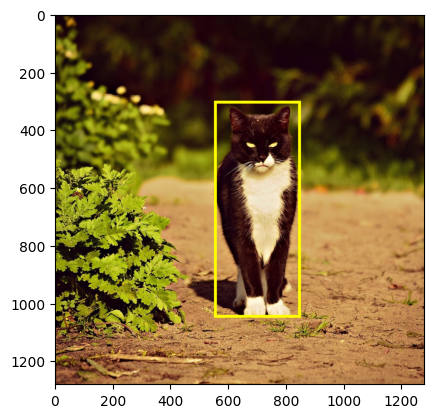

In [20]:
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw

image=Image.open("./resources/cat.jpg")

boxes=[
    [550,300,850,1050]
]

draw=ImageDraw.Draw(image)
for box in boxes:
    draw.rectangle(box,outline='yellow',width=10)

plt.imshow(image)
plt.axis()
plt.show()

### **区域卷积神经网络 R-CNN**

#### **R-CNN**

R-CNN首先从输入图像选取若干提议区域(如锚框),并标注类别和边界框,之后用CNN对每个提议区域向前传播提取特征,接着用提议区域特征来预测类别和边界框
- 对输入图像选择性搜索来选取多个高质量提议区域(通常是在多个尺度下选区的),提议区域由不同形状和大小,每个提议区域都被标注类别和真实边界框
- 选择一个预训练CNN(输出层前截断),将每个提议区域变形为网络需要的输入尺寸,向前传播提取特征
- 每个提议区域特征连同其标注的类别作为一个样本,训练多个支持向量机目标分类,每个向量机用来判断样本是否属于一个类别
- 将每个提议区域特征连同标注的边界框作为样本,训练线性回归模型预测真实边界框

#### **Fast R-CNN**

![fast rcnn](./resources/fast-rcnn.png)

R-CNN性能瓶颈在于每个提议区域的向前传播是独立的,而这些区域通常有重叠,独立特征抽取会重复计算,Fast R-CNN仅在整张图象上执行向前传播
- Fast R-CNN以整张图像而不是提议区域作为提取特征输入,此外提取特征的CNN会参与训练,CNN输出形状记为$1 \times c \times h_1  \times w_1$
- 假设选择性搜索生成了$n$个提议区域,形状不同的提议区域在CNN输出上分别标出了形状不同的兴趣区域。感兴趣的区域需要进一步抽取出形状相同的特征(指定的$h$和$w$),便于连接后输出,Fast R-CNN为此引入了兴趣区域汇聚层(RoI pooling):将CNN输入和提议区域作为输入,输出连接后的各提议区域抽取的特征形状为$n \times c \times h_2 \times w_2$；
- 通过全连接层输出形状变为$n \times d$, $d$取决于模型设计
- 预测$n$个区域中每个区域的类别和边界框,将全连接层输出转换为$n \times q$($q$是类别的数量)和$n \times 4$的输出,其中预测类别选用softmax回归

**RoI汇聚层**

传统的汇聚层通过设置汇聚窗口,填充和步幅来控制输出形状。RoI直接对每个区域输出形状指定。如RoI指定每个区域输出的高和宽分别为$h_1$和$w_1$,对任何形状为$h \times w$的区域,RoI汇聚层将其变形为$h_1 \times w_1$个子窗口。每个子窗口大小为$h/h_1 \times w/w_1$。每个子窗口都进行最大池化操作,并将每个子窗口的最大值拼接在一起,形成固定大小的输出特征图。实践中每个子窗口的高宽需要向上取整。

**torchvision.ops.roi_pool(input,rois,output_size,spatial_scale)**<br>
params:特征图(N,C,H,W) 提议区域形状(batch,x1,y1,x2,y2)<br> 输出形状(n,c,h,w)n表示提议区域数量 空间缩放比例(0.1表示输入图像缩放到0.1倍)

[RoI Pooling使用例](./CV-exam/RoI.py)

#### **Faster R-CNN**

为精确检测目标结果,Fast R-CNN模型通常需要在选择性搜索中生成大量提议区域,Faster R-CNN使用区域提议网络RPN替换选择性搜索,减小提议区域生成数量,保证目标检测精度

RPN计算步骤:
- 使用填充1的$3 \times 3$ CNN输出,并将输出通道数记为$c$。这样CNN为图像抽取的特征图每个单元均得到一个长度为$c$的新特征
- 以特征图每个像素为中心生成锚框作为候选区域
- 使用锚框中心单元长度为$c$的特征,预测该锚框二元类别(背景/目标)和边界框
- 使用NMS筛选候选区域,最终输出的预测边界框就是RoI需要的提议区域

RPN是和整个模型一起训练得到的,训练时不仅包括目标检测中的类别和边界框预测,还包括RPN的锚框的二元类别和边界框预测。RPN能学习如何生成高质量提议区域

**models.detection.RegionProposalNetwork**

RegionProposalNetwork(AnchorGenerator,rpn_head,fg_iou_thresh,<br>
bg_iou_thresh,batch_size_per_image,positive_fraction,pre_nms_top_n,<br>post_nms_top_n,nms_thresh)<br>创建对象实例,对象接受Images和features输入<br>
params:<br>
锚框生成器 锚框预测头<br> 
前景(目标)IoU阈值
背景IoU阈值<br> 
每个图像的正样本数量(每张图像用于RPN训练的锚框数量)<br> 
正样本比例(前景在训练样本中的比例)<br> 
前N个提议区域(每张图像中应用NMS前保留N个提议区域)<br> 
后N个提议区域(每张图像中应用NMS后保留N个提议区域)<br> 
NMS阈值(NMS中IoU阈值)<br>

*对前景和背景IOU阈值的解释*:若一个锚框与任意真实框IoU大于前景阈值就标记为前景锚框,与任意真实框IoU小于背景阈值就标记为背景锚框,若锚框与任何真实框IOU介于两者之间就丢弃

**rpn.RPNHead(in_channels,num_anchors)** 训练阶段对每个锚框二分类,预测锚框属于背景还是前景(目标);预测阶段的结果用于生成提议区域<br>
params:输入通道数 锚框数量<br>

[RPN使用例](./CV-exam/RPN.py)


#### **Mask R-CNN**

![mask rcnn](./resources/mask-rcnn.png)

若训练集包含每个目标在图像上的像素级位置,Mask R-CNN可以利用这些信息提升目标检测精确度

将Faster R-CNN的RoI替换为了兴趣区域对齐层(RoI Align),RoI Align输出包含所有与兴趣区域形状相同的特征图,不仅用于预测每个兴趣区域类别和兴趣课,还通过额外全卷积网络预测像素级位置

RoI Align步骤:
- 类似RoI Pooling,划分为固定大小子窗口
- 但在子窗口内使用双线性插值计算特征值而不是取最大值,可以更精确反映原始特征信息
- 拼接输出

**torchvision.ops.roi_align(input,rois,output_size,spatial_scale)**<br>
params:特征图(N,C,H,W) 提议区域形状(batch,x1,y1,x2,y2)<br> 输出形状(n,c,h,w) 空间缩放比例(0.1表示输入图像缩放到0.1倍)



### **转置卷积**
常见的卷积网络如卷积层和汇聚层通常会减少下采样输入的图像的空间维度(高和宽),然而如果输入和输出图像空间维度相同，以像素级分类的语义分割中很方便

为实现上述目标，尤其是在空间维度被CNN缩小后，使用**转置卷积(transposed convolution)层**逆转下采样导致的空间尺寸减小

转置卷积计算:
1. 若输入特征图大小为$(H,W)$,卷积核大小为$(h,w)$,输出特征图的大小将会是$(H+h-1,W+w-1)$
2. 遍历特征图的元素$(i,j)$，令特征图的每一个值分别和卷积核相乘，将得到的结果矩阵输出到输出特征图上的对应区域$(i:i+h,j:j+w)$

In [21]:
def trans_conv(X, K):
    # 简单实现
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j: j + w] += X[i, j] * K
    return Y

#### **填充、步幅和通道**

**填充**：常规卷积将填充应用于输入，转置卷积将填充应用于输出。如将高宽两侧填充指定为1，转置卷积的输出将删除第一和最后的行和列

如对$[[0,0,1],[0,4,6],[4,12,9]]$应用$padding=1$，结果会是$[[4]]$

**步幅**：步幅在转置卷积中也将被用于输出而不是输入,若步幅$stride=s$,输出特征图形状将是$(H \times s + h - s,W \times s + w - s)$

**通道**：对于多个输入输出通道，转置卷积和普通卷积以同样的机制运行。假设输入通道是$c$,转置卷积的卷积核张量是$k_h \times k_w$,则每个输出通道将有一个$c \times k_h \times k_w$的卷积核

#### **双线性插值**

有时，需要将图像放大，即进行上采样(upsmpling)操作。双线性插值(bilinear interpolation)是常用的上采样方法,双线性插值常用于**图像放大、转置卷积初始化、语义分割**,原理如下:

1. 将输出图像的坐标$(x,y)$映射到输入图像的坐标$(x',y')$上。
例如，根据输入与输出的尺寸之比来映射。映射后的$x′$和$y′$是实数。
2. 在输入图像上找到离坐标$(x',y')$最近的4个像素。
3. 输出图像在坐标$(x,y)$上的像素依据输入图像上这4个像素及其与$(x',y')$的相对距离来计算。

转置卷积默认已经实现了该操作

#### **nn.ConvTranspose2d(in_channels,<br>out_channels,kernel_size,stride,padding)**
params:类似nn.Conv2d<br>
卷积核权重一般为随机初始化,但也可以通过ConvTransposed2d的对象的weight属性指定权重
```python
conv=nn.ConvTranspose2d(1,3,2)
# weight形状为(out_channels,in_channels,kernel_h,kernel_w)
kernel=torch.tensor([[[[1,2],[3,4]]]],dtype=torch.float32)
conv.weight=nn.Parameter(kernel)
```
若输入特征图大小为$(H,W)$,卷积核大小为$(h,w)$,stride=s,padding=p,输出的特征图形状:
$$((H-1) \times s+h-2p, (W-1) \times s+w-2p)$$

### **全卷积网络**

语义分割是对图像中每个像素进行分类，全卷积网络(Fully Convoluional Network)FCN采用CNN实现了从图像像素到像素类别的变换

FCN将中间层特征图的高宽变回输入图像尺寸(依靠转置卷积),因此输出的类别预测与输入图像在像素级别上具有一一对应关系：通道维度的输出就是该位置对应像素的类别预测

#### **模型设计**

FCN先使用卷积神经网络提取图像特征，然后用$1 \times 1$卷积核将通道数变为类别个数，最后在转置卷积层将特征图高和宽变为输入图像尺寸

FCN语义分割的原理:
- 转置卷积通过可学习的卷积核参数，将低分辨率特征图逐步上采样到高分辨率。转置卷积的参数在训练过程中优化，能够自适应地恢复细节和物体形状。
- 最后一层的通道数等于类别个数，逐像素softmax选择概率最高的类别作为最终标签

[FCN使用例](./CV-exam/FCN.py)

### **风格迁移**

风格迁移(Style Transfer)时一种自动将一个图像的风格应用到另一图像上的技术。通常需要两张图像，一张内容图像，一张风格图像

首先，初始化合成图像，如将其初始化为内容图像，这是风格迁移中唯一需要更新模型参数的步骤。之后选择一个预训练神经网络抽取图像特征，其中的参数无需更新。对于抽取特制的神经网络，我们可以选择其中的某些层的输出作为内容/风格特征。一般来说，越靠近输入层，越容易提取到细节信息，反之易于获取全局信息。为避免合成图像过多保留内容图像细节，一般选择较靠近输出的层，即内容层来输出图像的内容特征。还可以选择不同层输出来匹配局部和全局风格，这些层称为风格层

然后，我们通过前向传播计算风格迁移的损失函数，再用反向传播迭代模型，即不断更新合成图像。风格迁移常用的损失函数由三部分组成:
- 内容损失使合成图像与内容图像在内容特征上接近
- 风格损失使合成图像与风格图像在风格特征上接近
- 全变分损失助于减少合成图像的噪点

风格迁移的损失函数是内容损失、风格损失和总变化损失的加权和

![风格迁移](./resources/style.png)

### **常用的骨干网络**
Torchvision中性能较好的预训练模型：

- ResNet50/101 - 经典可靠
- EfficientNet-B0/B1 - 参数量小性能好
- ResNeXt50/101 - 比ResNet精度高
- DenseNet121 - 特征复用好
- MobileNetV3 - 轻量级网络

## **强化学习(Reinforcement Learning,RL)**

什么是强化学习？ 强化学习是一系列技术，用于构建能够进行序贯决策（sequential decision-making）的机器学习系统。也就是说，系统需要在一系列步骤中做出决策，每个决策都会影响后续的步骤和最终结果。

比如，包裹递送：从你在线下单到包裹送达，涉及一系列决策（如从哪个仓库发货、选择陆运还是空运等）。途中的许多变量（如仓库是否有货、运输时长等）会影响整个过程，而这些变量往往不受我们控制。强化学习的目标是在每个阶段采取合适的行动，以最终最大化某个效用（如包裹准时送达）。

与标准深度学习的区别：<br>在标准深度学习中，模型对一个测试数据的预测不会影响对未来测试数据的预测；在强化学习中，未来的决策（在 RL 中也称为“动作”）会受到过去所做决策的影响

### **马尔科夫决策过程(MDP)**
马尔可夫决策过程（MDP）是一个模型，用于描述当对系统应用不同动作时，系统状态如何演变。构成一个 MDP 需要几个不同的要素:
- 令 $\mathcal{S}$ 为 MDP 中的 **状态(states)** 集合。举一个具体的例子，一个在网格世界中导航的机器人。在这种情况下，$\mathcal{S}$ 对应于机器人在任何给定时间步可能处于的位置集合。
  - 状态就是机器人（或者我们研究的智能体）可能所处的各种情况或位置。比如在一个迷宫里，机器人的状态可以是它在迷宫中的具体坐标
- 我们可能并不确切知道机器人如何移动，而只知道一个近似的情况。在强化学习中，我们这样对这种情况建模：如果机器人采取“前进”的动作，它可能有很小的概率停留在当前状态，另有很小的概率“左转”等。数学上，这相当于定义一个 **“转移函数”(transition function)**  $T: \mathcal{S} \times \mathcal{A} \times \mathcal{S} \to [0,1]$，使得 $T(s, a, s') = P(s' \mid s, a)$，这里使用条件概率表示在机器人处于状态 $s$ 并采取动作 $a$ 的情况下，到达状态 $s'$ 的概率。转移函数是一个概率分布，因此对于所有 $s \in \mathcal{S}$ 和 $a \in \mathcal{A}$，我们有 $\sum_{s' \in \mathcal{S}} T(s, a, s') = 1$，也就是说，如果机器人采取一个动作，它必须转移到某个状态。
  - 转移函数描述了世界的不确定性。当你让机器人“前进”时，它不一定 100% 会前进到预期的格子，可能因为地面打滑、传感器误差等原因，它会走到旁边的格子，或者原地不动。$T(s, a, s')$ 就表示在状态 $s$ 执行动作 $a$ 后，转移到状态 $s'$ 的概率。所有可能转移到的状态的概率加起来必须是 1。
- 现在，我们使用 **“奖励”(reward)** $r: \mathcal{S} \times \mathcal{A} \to \mathbb{R}$ 的概念来构建哪些动作有用、哪些动作没用的概念。我们说，如果机器人在状态 $s$ 采取动作 $a$，它会得到一个奖励 $r(s,a)$。如果奖励 $r(s, a)$ 很大，这表明在状态 $s$ 采取动作 $a$ 对于实现机器人的目标（例如，到达绿色的房子）更有用。如果奖励 $r(s, a)$ 很小，那么动作 $a$ 对于实现这个目标就没那么有用。重要的是要注意，奖励是由用户（创建强化学习算法的人）根据目标来设计的。
  - 奖励是一个即时反馈信号，告诉机器人它刚才做的动作好不好。比如，如果机器人走一步就离目标更近了，可以给一个正奖励；如果撞墙了，可以给一个负奖励（惩罚）；如果到达了目标，可以给一个很大的正奖励。这个奖励函数是我们自己设计的，用来引导机器人学习如何达成最终目标。

总的来说，一个马尔可夫决策过程 (MDP) 就是用这四个核心要素——状态、动作、转移函数和奖励函数——来数学化地描述一个序贯决策问题

#### **回报(Return)**
上面讨论的这些不同组成部分共同构成了一个马尔可夫决策过程（MDP）： $$\textrm{MDP}: (\mathcal{S}, \mathcal{A}, T, r).$$

现在，我们来考虑这样一种情况：机器人从一个特定的初始状态 $s_0 \in \mathcal{S}$ 开始，并持续采取动作，从而形成一个轨迹（trajectory）： $$\tau = (s_0, a_0, r_0, s_1, a_1, r_1, s_2, a_2, r_2, \ldots).$$ 在这个轨迹中，$s_t$ 是在时间步 $t$ 的状态，$a_t$ 是在状态 $s_t$ 采取的动作，$r_t = r(s_t, a_t)$ 是执行该动作后获得的即时奖励。

在每个时间步 $t$，机器人处于状态 $s_t$ 并采取动作 $a_t$，这会产生一个奖励 $r_t = r(s_t, a_t)$。一个轨迹的 **回报(return)**  是机器人沿着该轨迹获得的总奖励： $$R(\tau) = r_0 + r_1 + r_2 + \cdots.$$

强化学习的目标是找到一个具有最大回报的轨迹。

**“回报”** 就是对一条完整路径（从开始到结束的一系列状态、动作和奖励）的总评价。我们希望机器人能学到一条路径，使得这条路径上的奖励总和最大

不过，考虑这样一种情况：机器人在网格世界中持续移动，但从未到达目标位置。在这种情况下，轨迹中的状态和动作序列可能是无限长的，任何这种无限长轨迹的回报都将是无限的。为了使强化学习的表述即使对于这类轨迹也有意义，我们引入了折扣因子（discount factor） $\gamma < 1$ 的概念。我们将**折扣回报(discounted return)** 写为： $$R(\tau) = r_0 + \gamma r_1 + \gamma^2 r_2 + \cdots = \sum_{t=0}^\infty \gamma^t r_t.$$

如果一个任务可能永远不结束（比如机器人一直在迷宫里打转），那么简单地把所有奖励加起来可能会得到无穷大，这不利于比较不同策略的好坏。折扣因子的作用就是给未来的奖励打个折扣。$\gamma$ 是一个小于 1 的数（比如 0.9）。这意味着，即时奖励 $r_0$ 的权重是 1，下一步的奖励 $r_1$ 的权重是 $\gamma$，再下一步的奖励 $r_2$ 的权重是 $\gamma^2$，以此类推。时间越靠后的奖励，其权重就越小

如果 $\gamma$ 非常小，机器人在遥远的未来（比如 $t = 1000$ 时）获得的奖励会因为因子 $\gamma^{1000}$ 而被大幅度打折。这会鼓励机器人选择能够实现其目标的较短轨迹，例如在网格世界中到达目标地点。对于较大的折扣因子值，比如说 $\gamma = 0.99$，机器人则被鼓励去探索（explore），然后找到到达目标位置的最佳轨迹。

- 如果 $\gamma$ 接近 0（例如 0.1），机器人会更看重眼前的利益，倾向于“短视”，尽快拿到奖励。
- 如果 $\gamma$ 接近 1（例如 0.99），机器人会更看重长远的利益，有“远见”，愿意为了未来更大的总回报而牺牲一些眼前的即时奖励，这通常会鼓励更多的探索。
- 折扣回报的引入保证了即使在无限长的轨迹中，回报的总和也是一个有限值（因为 $\sum \gamma^t r_t$ 是一个收敛的级数，前提是每步的奖励 $r_t$ 有界）。

马尔可夫性质的核心思想是“未来只与现在有关，与过去无关”。也就是说，一旦知道了当前状态 $s_t$ 和当前采取的动作 $a_t$，那么预测下一个状态 $s_{t+1}$ 所需的所有信息都已经包含在 $s_t$ 和 $a_t$ 中了，不需要再回头看 $s_{t-1}, s_{t-2}, \ldots$ 等更早的状态。
看起来系统的马尔可夫性质似乎是一个限制性很强的假设，但事实并非如此。马尔可夫决策过程仍然能够对非常广泛的真实系统进行建模。

即使一个系统表面上看起来不满足马尔可夫性质（比如需要考虑前一个状态的速度），我们通常可以通过重新定义状态来使其满足马尔可夫性质。关键在于确保当前状态包含了预测未来所需的所有相关历史信息。在这个例子中，把速度也加入到状态定义中，就使得新的状态 $(\text{位置}, \text{速度})$ 包含了足够的信息来预测下一个 $(\text{位置}, \text{速度})$，而不需要再看更早的状态了。

### **价值迭代(Value Iteration)**
#### **随机策略**
一个表示为 $\pi(a \mid s)$ 的随机策略（简称策略）是给定状态 $s \in \mathcal{S}$ 下动作 $a \in \mathcal{A}$ 的一个条件分布，即 $\pi(a \mid s) \equiv P(a \mid s)$。举个例子，如果机器人有四个动作 $\mathcal{A}=$ {向左, 向下, 向右, 向上}。对于这样一组动作 $\mathcal{A}$，在某个状态 $s \in \mathcal{S}$ 下的策略可以是一个分类分布，其中四个动作的概率可能是 $[0.4, 0.2, 0.1, 0.3]$；而在某个其他状态 $s' \in \mathcal{S}$，同样这四个动作的概率 $\pi(a \mid s')$ 可能是 $[0.1, 0.1, 0.2, 0.6]$。请注意，对于任何状态 $s$，我们都应该有 $\sum_a \pi(a \mid s) = 1$。**确定性策略(deterministic policy)** 是随机策略的一种特殊情况，在这种情况下，分布 $\pi(a \mid s)$ 只会给某个特定动作赋予非零概率，例如，在我们有四个动作的例子中，可能是 $[1, 0, 0, 0]$。

- 策略 (Policy)：可以把它想象成机器人的“行动指南”或者“决策规则”。它告诉机器人在每个可能的状态下，应该如何选择动作。
- 随机策略 (Stochastic Policy)：这意味着机器人的行动指南不是“在状态 X，必须做动作 Y”，而是“在状态 X，有 P1 的概率做动作 Y1，有 P2 的概率做动作 Y2，以此类推”。就像上面例子里的，在某个状态，机器人有 40% 的概率向左，20% 的概率向下等等。所有这些概率加起来必须是 100%（或者说 1）。
- 确定性策略 (Deterministic Policy)：这是随机策略的一个特例。在这种情况下，机器人的行动指南非常明确：“在状态 X，必须做动作 Y”。也就是说，对于某个动作，概率是 1 (100%)，其他所有动作的概率都是 0。
- 符号简化：$\pi(a \mid s)$ 明确表示“在状态 $s$ 下选择动作 $a$ 的概率”。有时为了方便，会简写成 $\pi(s)$，但它仍然代表的是在状态 $s$ 下关于所有动作的一个概率分布。

#### **价值函数**
- 状态价值 V(s)： 衡量一个状态 s 有多好。具体来说，如果机器人从状态 s 出发，并且按照某个策略行动，它未来能获得的平均总奖励（考虑了未来的奖励会打折）是多少。V(s) 越高，说明这个状态越有利。
- 动作价值 Q(s, a)： 衡量在状态 s 下，做一个特定的动作 a 有多好。具体来说，如果在状态 s 做了动作 a，然后继续按照某个策略行动，未来能获得的平均总奖励是多少。Q(s, a) 越高，说明在当前状态下做这个动作越明智。



#### **价值函数的贝尔曼方程**
- 核心思想： 一个状态（或状态-动作对）的价值，可以由它“下一步”能获得的即时奖励，以及“下一步所有可能状态的价值”来共同决定。
- 简单来说： 我现在这个位置好不好，取决于我下一步能马上拿到多少好处，以及我下一步会走到哪些位置、那些位置又有多好。

#### **最优价值函数与最优策略 - 最终目标**
- 最优价值函数 (V* 和 Q*)： 就是在所有可能的策略中，能达到的最好的价值。V*(s) 表示从状态 s 出发，能获得的最大期望总回报。
- 最优策略 ($\pi$*)： 就是那个能让我们获得最优价值函数的行动指南。在每个状态下，它会选择能带来最大 Q* 值的动作。

#### **价值迭代——找到最优价值的方法**
它是一种“猜”并不断“修正”的方法。
1. 开始时，随便给每个状态的价值 V(s) 赋一个初始值（比如都是0）。
2. 然后不断迭代：对于每个状态 s，考察所有可能的动作 a。对于每个动作 a，计算“如果我做了动作 a，能得到的即时奖励 + 折扣后下一状态的（上一轮估计的）价值”。
3. 选择那个能让这个总和最大的动作，把这个最大的总和作为状态 s 的新价值。
4. 重复这个过程，直到所有状态的价值都不怎么变化了，这时候得到的价值就接近最优价值 V* 了。

**目标**： 直接算出最优价值函数 V*。一旦有了 V*，最优策略也就知道了（在每个状态选那个能达到 V* 的动作）。
#### **策略评估 (Policy Evaluation) - 评估现有策略的好坏**
和价值迭代很像，也是“猜”并“修正”。
1. 我们已经有了一个固定的行动指南（策略 $\pi$）。
2. 开始时，随便给每个状态的价值 V(s) 赋一个初始值。
3. 然后不断迭代：对于每个状态 s，根据我们已有的策略 $\pi$，计算“按照这个策略行动，我能得到的即时奖励 + 折扣后下一状态的（上一轮估计的）价值”的期望值。
4. 把这个期望值作为状态 s 的新价值。
5. 重复这个过程，直到所有状态的价值都不怎么变化了，这时候得到的价值就是当前策略 $\pi$ 对应的价值 V $^\pi$。
**目标**： 计算出当前这个“行动指南”到底有多好。

---
总结上述：
- 首先，我们要明确智能体（Agent）所处的环境有哪些可能的状态 (States)。比如，在游戏中，是棋盘的布局；在机器人导航中，是机器人的位置。然后，我们要给智能体设定它在每个状态下可以执行的基本操作 (Actions)。比如，棋类游戏中是下子，机器人是前进、后退、左转、右转。
- 接下来，我们要设计一个奖励 (Reward) 机制。智能体在某个状态下执行某个动作后，会得到一个即时奖励（或惩罚）。这个奖励信号是引导智能体学习的关键，告诉它什么是“好”的行为，什么是“坏”的行为。智能体的最终目标是学习一个策略 (Policy)——也就是一套决策规则——使得它从开始到结束（或者在持续的任务中）能够获得的累积奖励总和最大化。或者说“找到价值最高的决策路径”。
- 智能体在做下一步决策时，通常只依赖于当前所处的状态。它不需要记住完整的历史路径，当前状态已经包含了做出最优决策所需的所有相关信息。
- 智能体的策略会告诉它在当前状态下应该选择哪个动作（或者以多大概率选择哪个动作）。这个策略的优劣，以及每个状态的“好坏程度”，可以用价值函数 (Value Function) 来衡量。状态的价值通常由它能带来的期望累积奖励决定。
- 智能体通过与环境的交互（尝试不同的动作并观察结果和奖励）或者通过模型进行迭代计算（像我们讨论的价值迭代），来不断更新和改进它的策略和对状态价值的估计。
- 一旦智能体学习到了比较准确的价值函数（比如知道了在每个状态下，采取哪个动作能带来最高的长期回报，即最优Q值），那么在决策时，它往往会贪心地选择那个能带来最大期望价值的动作。
- 在学习的早期阶段，纯粹的贪心可能会让智能体陷入局部最优（比如只走自己熟悉但并非最好的路）。因此，RL算法通常会引入“探索 (Exploration)”机制，让智能体偶尔尝试一些非贪心的动作，以便发现可能存在的更好路径。最终的目标是收敛到一个既能充分利用已知信息（贪心/Exploitation）又能发现新机会（探索/Exploration）的最优或接近最优的策略。

### **Q-Learning**
这是一种价值函数算法，该算法体现了强化学习的核心思想：它将使机器人能够获取自己的数据。

#### **无模型学习**
Q-Learning不需要完整的“地图”信息（也就是完整的马尔可夫决策过程模型，特别是状态转移概率 $P(s'|s,a)$）。
相反，机器人（或者叫智能体）是通过实际“玩游戏”（与环境交互）并观察发生什么来学习的。这就像通过不断尝试、摔倒、调整来学骑自行车，而不是通过阅读一本关于自行车动力学的物理教科书。

##### **样本学习**
价值迭代的公式中需要对所有可能的下一个状态 $s'$ 进行求和。Q-Learning 巧妙地绕过了对 $P(s'|s,a)$ 的需求，它使用的是机器人在状态 $s$ 采取动作 $a$ 后，实际观察到的那个下一个状态 $s'$。

可以这样理解：价值迭代像是通过知道骰子是六面均匀的来计算掷骰子的平均结果，而 Q-Learning 则是实际掷一下骰子，看到结果，然后用那个具体的结果来更新自己的判断。通过大量的尝试，它最终也能得到一个很好的估计。

##### **学习规则(更新Q值)**
Q-Learning 尝试让它当前对 $Q(s,a)$（在状态 $s$ 采取动作 $a$ 的价值）的估计值，更接近一个“目标”值。

$Q(s,a)$的定义是：在状态 s 执行动作 a，然后遵循最优策略，所能获得的期望累积折扣回报。其含义是未来回报的总和

这个“目标”值是这样计算的：（我刚刚获得的即时奖励 $r$）+（从我到达的下一个状态 $s'$ 出发，能得到的最好的、打过折的 Q 值）。

更新规则的核心意思是：“我以前估计 $Q(s,a)$ 是 X。我刚刚在状态 $s$ 试了动作 $a$，得到了奖励 $r$，然后到了状态 $s'$。从 $s'$ 出发，我（根据我目前的 Q 表）能得到的最好结果是 $\max_{a'} Q(s', a')$。所以，$Q(s,a)$ 的一个更好估计可能是 $r + \gamma \max_{a'} Q(s', a')$。那么，我就把我旧的估计 X 朝着这个新目标调整一点点。”
“调整一点点”的幅度由一个学习率 ($\alpha$) 控制。

##### **从轨迹中学习**
机器人通过在环境中移动来收集数据，形成一系列的 (状态, 动作, 奖励, 下一个状态) 序列。这就像是它的经验日志。

Q-Learning 使用这些记录下来的经验（通常称为“转移”或“样本”）来进行 Q 值的更新。每一个这样的经验 $(s_t, a_t, r_t, s_{t+1})$ 都为更新 $Q(s_t, a_t)$ 提供了一条信息。

##### **终止状态**
当机器人到达目标或者“游戏结束”的状态（终止状态）时，从那个状态开始就不会再有未来的奖励了。
所以，在计算 $Q(s,a)$ 的目标值时，如果动作 $a$ 导致进入了一个终止状态 $s'$，那么“从下一个状态能得到的最好 Q 值”那一部分就变成零了。因为终止状态本身通常被认为价值为零，因为整个回合结束了。

##### **从 Q 值得到策略**
一旦 Q-Learning 运行了一段时间，并且 Q 值（理想情况下）收敛到了对最优动作价值 ($Q^*$) 的良好估计，那么找出最佳策略就很简单了。
在任何状态 $s$，最佳的动作就是那个具有最高 $\hat{Q}(s,a)$ 值的动作：$\hat{\pi}(s) = \mathrm{argmax}_{a} \hat{Q}(s, a)$。这是一种相对于学习到的 Q 值的“贪心”策略。

#### **Q-Learning中的探索**
Q-Learning 是通过机器人自己收集的数据来学习的。如果机器人用来收集数据的策略（我们称之为 $\pi_e$）总是走同样的路，或者只去它已经知道的“好地方”，那么它可能永远发现不了那些它没去过但实际上更好的地方。

这就好比你每次都去同一家你觉得还不错的餐馆，可能永远不会发现街角那家其实更美味的餐馆。
如果数据收集得不够多样，我们学到的 Q 值 ($\hat{Q}$) 就会不准，而且这种不准确会影响到所有状态的 Q 值估计，因为 Q 值是相互关联的。所以，选择一个好的数据收集策略 $\pi_e$ 非常关键。

##### **探索策略**
- 完全随机策略：一种简单的方法是让机器人完全随机地选择动作。这样它最终会逛遍所有地方，但效率可能很低，需要非常非常多的尝试。
- $\epsilon$-贪心策略 ($\epsilon$-greedy)：这是 Q-Learning 中一个非常经典和常用的探索方法。
  - 机器人大部分时间（以 $1-\epsilon$ 的概率）会选择当前它认为最好的动作（即根据当前的 $\hat{Q}$ 值，选择那个 $\mathrm{argmax}_{a'} \hat{Q}(s, a')$）。这叫作“利用 (exploitation)”。
  - 但它也会以一个较小的概率 $\epsilon$（比如 10% 的概率）随机选择一个动作，而不是当前认为最好的那个。这叫作“探索 (exploration)”。
  - $\epsilon$ 的值由我们设定，它控制了机器人有多大的“好奇心”去尝试新事物。
- Softmax 探索策略：另一种方法是根据当前 $\hat{Q}(s,a)$ 值的大小来决定选择每个动作的概率。$\hat{Q}(s,a)$ 值越高的动作被选中的概率也越大，但即使是 $\hat{Q}(s,a)$ 值较低的动作也仍有一定概率被选中。这种概率分布的“形状”由一个叫做“温度 (temperature) $T$”的参数控制。温度越高，动作选择越趋向于随机；温度越低，越趋向于选择当前最好的动作。

##### **探索与学习结合**
当探索策略本身也依赖于当前估计的 Q 值时（比如 $\epsilon$-贪心或 Softmax），我们就需要周期性地更新 Q 值。

通常的做法是，机器人每执行一次动作（根据探索策略 $\pi_e$），收集到新的经验数据后，就用这些新数据（通常是最近收集到的一小批）来更新一次 Q 值。

##### **为何探索有效？**
这是 Q-Learning 非常巧妙的一点。随着机器人收集的数据越来越多，它的探索策略 $\pi_e$ 和 Q 值估计 $\hat{Q}$ 都会不断演变。
- 好的方面：如果某个动作 $a$ 在当前状态 $s$ 下的 $\hat{Q}(s,a)$ 值很高（即机器人认为这是个好动作），那么探索策略（无论是 $\epsilon$-贪心还是 Softmax）都会更倾向于选择这个动作。如果这个动作确实好，那么它会带来好的奖励，Q-Learning 的更新会进一步强化这个 $\hat{Q}(s,a)$ 值，使得机器人更喜欢这个动作。
- 坏的方面（自我纠错）：如果某个动作 $a$ 的 $\hat{Q}(s,a)$ 值被高估了（机器人错误地认为它是个好动作），探索策略同样会更倾向于选择它。但是，当机器人执行了这个“坏”动作后，它会发现后续得到的奖励并不好。于是，Q-Learning 的下一次更新就会降低这个被高估的 $\hat{Q}(s,a)$ 值。这样一来，下次机器人再遇到状态 $s$ 时，选择这个“坏”动作的概率就会降低。

简单来说，机器人会去探索那些它认为有价值的动作。如果探索后发现确实好，就继续；如果发现不好，就修正自己的看法。这种“试错并修正”的能力使得 Q-Learning 即使从一个随机策略开始，也能逐渐学习到最优策略。

Q-Learning 这种不仅能收集新数据，还能主动收集“正确类型”的数据（通过探索和利用的平衡）的能力，是强化学习算法的核心特征，也是它与监督学习的关键区别。在监督学习中，数据是给定的，模型只是被动学习；而在强化学习中，智能体主动与环境交互来产生和选择数据。

#### **总结Q-Learning**
Q-learning 是一种解决马尔可夫决策过程 (MDP) 的方法，它通过学习一个动作价值函数 (action-value function)$Q(s,a)$ 来实现<br>
 $Q(s,a)$表示智能体 (agent) 在状态 $s$(state) 执行动作 $a$(action) 后，并从此刻开始遵循某一特定策略 (在Q-learning中，这个目标策略是最优策略) 所能获得的期望累积折扣回报 (expected cumulative discounted reward)。

对于离散且状态和动作空间较小的环境，我们可以使用一个Q表 (Q-table) 来存储$Q(s,a)$的值，Q表是一个二维表格（或多维数组），其行索引对应状态 $s$,列索引对应动作$a$,表格中的每个单元格存储了对应$(s,a)$对的Q值(即期望累计折扣回报)

为了平衡探索 (exploration) 与利用 (exploitation)，智能体通常采用一种行为策略 (behavior policy)，例如 ε-greedy策略。执行选定动作$a$后，智能体观测到即时奖励$r$和下一状态$s'$,然后使用 
**Q-learning更新规则（其灵感来源于贝尔曼最优方程** 来更新 $Q(s,a)$：
$$Q(s,a) \leftarrow Q(s,a) + \alpha \cdot [r + \gamma \cdot \max_{a'} Q(s',a') - Q(s,a)]$$
    
- $r + \gamma \cdot \max_{a'} Q(s',a')$ 被称为 **TD目标 (TD Target)**。它代表了对 $Q(s,a)$ 的一个基于单步经验的、新的估计值。其中：
  - $r$ 是即时奖励。
  - $\gamma$ 是折扣因子 (discount factor)。
  - $\max_{a'} Q(s',a')$ 是在下一个状态 $s'$ 时，根据当前Q表所能获得的**最大未来期望回报的估计**（这体现了Q-learning学习的是**最优策略**，即目标策略是贪婪的）。
- $r + \gamma \cdot \max_{a'} Q(s',a') - Q(s,a)$ 被称为 **时序差分误差 (Temporal Difference Error, TD Error)**。它表示TD目标与当前 $Q(s,a)$ 估计值之间的差异。
- $\alpha$ 是学习率 (learning rate, lr)，它控制了用TD Error更新 $Q(s,a)$ 的步长。
- 这个更新过程使得 $Q(s,a)$ 逐渐逼近其真实的最优动作价值。

可以通过[机器人学习走路](./utils/Q_Learning.py)这个实例来理解

## **高斯过程(Gaussian Processes)**

In [22]:
import gpytorch
print(gpytorch.__version__)

1.7.0


高斯过程（GP）是一种灵活的概率模型，可以用来直接对函数进行建模。它们在许多领域表现出色，并且可以通过先进的算法与深度学习相结合，提供函数空间的建模视角。学习高斯过程不仅有助于理解模型，还提供了重要的数值方法基础。

### **核心思想**
- 传统的机器学习（如神经网络）通常关注从数据中估计难以解释的参数（如权重）。
- 相比之下，高斯过程（GP）可以直接关注函数本身的高层性质（如变化快慢、周期性等），并通过在高斯分布中直接指定函数值来建模。这使得将我们对函数形式的先验知识轻松融入模型成为可能。

#### **工作流程**

1. 观察数据：给定一组数据，我们需要思考数据的特性，比如变化速度、间隔是否规律，以及如何填充缺失区域或进行预测。
2. 指定先验(Prior): 在观察数据之前，我们首先根据对函数形式，指定一个可能的函数分布（先验）。这个先验反映了我们认为合理的函数应该具备哪些高层性质（例如变化速度）。我们从这个先验中抽取样本函数，看看它们是否符合我们的直觉。
3. 数据推断得到后验(Posterior):  一旦我们有了数据，就可以根据数据修正先验，推断出一个更精确的函数分布（后验）。从后验中抽取的样本函数都能完美地穿过我们观测到的数据点。
4. 进行预测：
  - 点预测： 对所有可能的后验样本函数的取值进行平均（后验均值），得到一条用来进行点预测的曲线。
  - 不确定性度量： 后验样本函数的变化程度反映了我们对预测的不确定性（称为认知不确定性或可归约不确定性）。数据越多，这种不确定性越小。我们可以计算后验方差来衡量这种不确定性。
5. 可视化预测结果： 通常将观测数据、后验均值以及表示不确定性的置信区间一起展示。置信区间（例如，均值上下两个标准差范围）表示真实函数值有很大可能落入的范围。注意到，在没有数据的地方，不确定性会随着远离数据点而增加，这是认知不确定性的典型特征。
---
- 高斯过程定义了一个“函数上的分布”，不是对一组特定的数据构造一个函数，而是定义了**所有可能的函数**的一种概率分布。这个分布的特点是，你从这个分布里**任意取出一组输入点**$x_1,x_2,x_3...$，它们对应的函数值$f(x_1),f(x_2),f(x_3)$总是遵循一个联合多元高斯分布

- 先验 (Prior)：在我们看到任何数据之前，高斯过程定义的这个函数分布(**是假设的所有函数！！!**)就是先验分布。它反映了我们对可能函数的“猜测度”或者“第六感”(或是预判)，由均值函数和核函数决定。从先验中采样的函数是符合我们设定的性质（如平滑性、波动性）的函数样本

-  当我们观测到了一组数据点$(x_1,y_1),(x_2,y_2)$,利用这些数据来“限制”先验分布。本质上，我们计算的是**在已知函数$x_1,...,x_n$点上的取值分别为$y_1,...,y_n$的情况下，函数在其他任意点$x$上的取值分布是什么？这个条件分布就是后验分布**。也就是说，我们用数据重新分配了我们先验中所有假设函数的权重，越拟合数据且平滑的函数权重越高。置信区间则意味着对任意输入$x$,我们有多少概率(或把握)，其对应的$f(x)$会落在哪个区间内[下限，上限]

- 后验分布告诉我们对于任意新的输入点 $x$，其函数值 $f(x)$ 的概率分布（仍然是高斯分布）。这个后验高斯分布的**均值**就是我们对 $f(x)$ 的**点预测值**，也就是“后验均值”。这个后验高斯分布的**方差**则度量了我们预测的**不确定性**，也就是“后验方差”。
#### **协方差(核函数)的重要性**


**协方差函数（核函数）的重要性：**

-   高斯过程的特性，以及如何拟合数据，很大程度上由一个叫做**协方差函数**（也称为**核函数**）的函数控制。
-   协方差函数决定了函数在不同输入点上的取值之间的关联程度。

#### **以RBF 核函数作为示例：**

-    **RBF 核函数**，其形式为 $k_{\textrm{RBF}}(x,x') = \textrm{Cov}(f(x),f(x')) = a^2 \exp\left(-\frac{1}{2\ell^2}||x-x'||^2\right)$。
-   这个核函数有两个可解释的**超参数**：
    -   **振幅 ($a$)：** 控制函数的垂直变化幅度。$a$ 越大，函数值的变化范围越大。
    -   **长度尺度 ($\ell$)：** 控制函数的波动速率或平滑程度。$\ell$ 越大，函数变化越慢（越平滑）。

**长度尺度 ($\ell$) 的影响：**

-   长度尺度对高斯过程的预测和不确定性影响尤其显著。
-   当两个输入点 $x$ 和 $x'$ 之间的距离 $||x-x'||$ 等于 $\ell$ 时，函数值 $f(x)$ 和 $f(x')$ 之间的协方差为 $a^2\exp(-0.5)$。
-   当距离大于 $\ell$ 时，函数值之间的相关性会变得非常小。这意味着，当我们想预测一个点 $x_*$ 的函数值时，那些距离 $x_*$ 大于 $\ell$ 的数据点对预测的影响会很弱。
-   不同的长度尺度会导致样本先验函数、后验函数和置信区间呈现出显著差异。例如，在一个较大的输入范围内，一个很小的长度尺度（如 0.1）意味着函数值在相距不远的点（如 $x=5$ 和 $x=10$）之间几乎没有相关性；而一个较大的长度尺度（如 10）意味着这些点之间的函数值会高度相关。

##### **长度尺度和振幅对函数形态的影响：**

-  **长度尺度 ($\ell$)：** 随着长度尺度的增加，函数的“波动性”减少，变得更平滑，不确定性也降低。如果长度尺度很小，那么远离数据点的地方，不确定性会迅速增加，因为数据点之间的信息关联减弱。
-  **振幅 ($a$)：** 振幅主要影响函数的整体垂直尺度，但**不改变**函数的波动速率。振幅越大，函数的取值范围越大。


##### **超参数的选择与优化：**
- 核函数的超参数（如 `a` 和 `l`）的选择对高斯过程的泛化性能至关重要。选择合适的超参数可以得到更好的拟合效果。
- 存在一种**可靠且自动**的方法来确定这些超参数，称为**边缘似然 (marginal likelihood)**。

#### **高斯过程的数学定义**
-   高斯过程的本质是：**任意一组输入点上的函数值集合都遵循一个联合多元高斯分布。**
-   这个联合高斯分布的：
    -   **均值向量 ($\mu$)** 由一个**均值函数 (mean function)** 给出，通常设置为常数或零。
    -   **协方差矩阵** 由**核函数**在所有输入点对上进行评估得到。
-   给定已经观测到的函数值（数据），我们可以计算任意新的输入点 $x$ 上的函数值 $f(x)$ 的**条件分布**，这就是**后验分布 (posterior)**。我们使用这个后验分布来进行预测。

##### **利用后验分布进行预测：**
-   给定观测数据 $f(x_1), \dots, f(x_n)$，新输入点 $x$ 的函数值 $f(x)$ 的后验分布是一个**单变量高斯分布**：$f(x) | f(x_1), \dots, f(x_n) \sim \mathcal{N}(m,s^2)$。
-   其中：
    -   $m$ 是**后验均值**，用于作为点预测值。它可以通过公式 $m = k(x,x_{1:n}) k(x_{1:n},x_{1:n})^{-1} f(x_{1:n})$ 计算得出。
    -   $s^2$ 是**后验方差**，用于衡量预测的不确定性。它可以通过公式 $s^2 = k(x,x) - k(x,x_{1:n})k(x_{1:n},x_{1:n})^{-1}k(x,x_{1:n})$ 计算得出。
-   要创建包含真实函数值 95% 概率的**置信区间 (credible interval)**，可以使用 $m \pm 2s$。

##### **举个例子**
-   假设我们只观测到一个数据点 $f(x_1)$，想预测另一个点 $x$ 上的函数值 $f(x)$。
-   由于 $f(x)$ 是高斯过程，我们知道 $(f(x), f(x_1))$ 的联合分布是一个二元高斯分布。
-   这个联合分布的协方差矩阵包含了 $k(x,x_1)$，它衡量了 $f(x)$ 和 $f(x_1)$ 之间的相关性。核函数的值越大，相关性越强，意味着 $f(x_1)$ 对 $f(x)$ 的决定作用越强。
-   更具体的说：
    -   相关性越强 ($k(x,x_1)$ 越大)，等概率线越窄，预测值 $f(x)$ 被约束的范围越小。
    -   后验均值会更接近观测到的 $f(x_1)$ 值。
    -   预测的不确定性（误差棒）会随相关性增强而减小。
-   然而，即使相关性很强，只观测到一个数据点时，不确定性仍然可能相当大。

### **GP帮助理解模型并提高泛化性**
在深度学习中，我们通常关注神经网络的权重这些参数，然后希望这些权重能学习出好的函数来拟合数据。高斯过程提供了一个不同的视角：我们可以直接思考我们认为“好的”函数应该长什么样，然后让模型去找到符合这些特征的函数

神奇的是，一个具有无限多隐藏单元的神经网络（在参数服从特定分布时），在函数空间看来，就是一个高斯过程。这意味着，即使我们训练一个非常大的神经网络，它的行为在某种程度上可以用一个高斯过程来理解，借助高斯过程，可以理解为什么巨大的神经网络有时表现得像更简单的模型（因为它们在高斯过程极限下具有特定的平滑性等属性）；利用高斯过程的一些理论工具（比如核函数的概念）来分析神经网络的泛化能力

传统视角下，关注点在参数，比如通过优化参数期望生成一条好的曲线，但很难靠参数本身理解其对曲线形态的影响

而高斯过程直接描述了对曲线形态的偏好

#### **通过GP理解神经网络**
一个“无限宽”的神经网络，它的输入输出关系，在数学上就等价于一个高斯过程，而且这个高斯过程的核函数是由网络的结构和激活函数决定的。对于非常大的神经网络，我们可以不再纠结于成千上万甚至上亿的权重参数，而是转而分析它等价的那个高斯过程的核函数，这个核函数告诉我们，这个巨大的网络本质上倾向于学习什么样的函数形态（是平滑的？有周期性？局部变化快？）

高斯过程通过核函数来直接控制函数形态的复杂性或平滑性，从而直接编码了对函数形态的先验知识：<br>
如果你选择了产生平滑函数的核函数，那么模型就不会去拟合训练数据中的尖锐波动（这些可能是噪声）。它会倾向于找到一条符合你设定的平滑度且最能解释数据的曲线。这种“形态上的约束”使得模型在训练数据点之间进行合理的插值或在数据点之外进行合理的外推。

斯过程通过其核函数，让你明确地告诉模型你希望找到的函数具备哪些高层性质（如平滑）。模型会优先寻找满足这些性质的函数。这种对函数形态的先验约束使得模型不容易去学习训练数据中的噪声，从而提高了在未见过数据上的泛化能力，尤其在数据量不是非常大时。

[GP可视化](./utils/GP_model.py)

## **生成对抗网络(GANs)**
机器学习有两种主要类型：
- 判别式学习： 主要用于区分数据样本和标签之间的映射关系，例如图像分类。深度神经网络在判别式任务上取得了巨大成功。
- 生成式建模： 旨在学习数据的特征，以便生成与训练数据分布相似的合成数据。Generative Adversarial Networks 生成对抗网络 是生成式建模的一种强大方法。

### **GANs的核心思想**
GANs 巧妙地利用了判别模型的强大能力来构建好的生成模型。<br>
GANs 的核心理念是：如果一个数据生成器生成的假数据与真实数据无法区分，那么这个生成器就是好的。这类似于统计学中的双样本检验。
与简单的双样本检验不同，GANs 利用这种无法区分的能力作为训练信号来改进生成模型。

GANs主要由两个部分组成
- 生成器网络 (Generator)： 负责生成看起来像真实数据的新数据。
- 判别器网络 (Discriminator)： 充当二分类器，试图区分输入数据是真实的还是由生成器生成的假数据。

这两个网络相互竞争：生成器试图欺骗判别器，而判别器则适应新的假数据。判别器的反馈信息又被用来改进生成器。

### **GANs的训练过程**
GANs的训练过程主要分为两个交替进行的阶段：
- 训练判别器：
  - 采样一批真实数据作为正样本。
  - 使用生成器（Generator）根据随机噪声生成一批“假”数据。
  - 使用真实数据和生成数据训练判别器，使其能够区分真实样本和生成样本。
  - 判别器的目标是最大化区分真实数据和生成数据的准确率。
- 训练生成器：
  - 使用随机噪声生成数据，并通过判别器判断生成数据的真实性。
  - 固定判别器的参数，更新生成器参数，使生成的数据更“逼真”以“欺骗”判别器。
  - 生成器的目标是最小化判别器对生成数据的准确判别（通常通过对抗损失函数实现）。

  ### **深度卷积生成对抗网络(DCGAN)**
  DCGAN 是一种特殊的 GAN，它将卷积神经网络（在计算机视觉判别任务中表现出色）的应用扩展到生成逼真的图像，它利用卷积架构的优势来处理和生成图像数据。

  #### **生成器**
  负责将一个低维的随机噪声向量（称为潜在变量 z）转换为高维的逼真图像。核心结构采用**转置卷积层**。
  核心结构：
  - 转置卷积层：增大输入的空间尺寸，使得生成器能够从一个小的噪声向量生成大尺寸的图像。
  - 基本块组成：转置卷积层、批量归一化层和ReLU激活函数

  #### **判别器**
   接收输入图像（可以是真实图像或生成器生成的假图像），并判断其是真实的还是假的。这是一个二分类任务。
   核心结构：
   - 普通的卷积神经网络和 Leaky ReLU 激活函数。
   - Leaky ReLU：对于正输入，它与 ReLU 相同（输出等于输入）；对于负输入，它不再像 ReLU 那样输出 0，而是输出一个小的非零值（αx，其中 α 是一个小的正数，通常在 0 到 1 之间

## **域自适应**
当训练数据（源域，Source Domain）和测试数据（目标域，Target Domain）来自相似但不同的数据分布时，传统的机器学习模型（尤其深度学习模型）性能会急剧下降。目标是利用源域的标注数据和目标域的未标注数据，训练出一个在目标域上表现良好的模型。

### **域对抗神经网络 (Domain-Adversarial Neural Networks, DANN)**
DANN 在神经网络框架内实现了上述理论思想。它包含三个主要部分：
- 特征提取器（Feature Extractor $G_f$）：负责从原始输入数据中学习特征表示。
- 标签预测器（Label Predictor $G_y$）：基于特征提取器提取的特征，对源域数据进行分类（最小化分类损失）。 
- 域分类器（Domain Classifier $G_d$）：同样基于特征提取器提取的特征，尝试区分输入数据是来自源域还是目标域（最小化域分类损失）。

特征提取器 $G_f$ 学习到的特征表示 $f = G_f(x)$，对于后续的域分类器 $G_d$ 来说，**应该无法判断这个特征 $f$ 究竟是来自源域的数据 $x_{source}$ 还是目标域的数据 $x_{target}$。**
    为什么需要这样的特征？因为如果特征对域是敏感的（能区分域），那么基于这些特征训练的标签预测器 $G_y$ 就可能会过度依赖源域的特定分布模式，导致在面对目标域的新分布时性能下降。如果特征能做到域不变（indiscriminate with respect to the shift between the domains），那么标签预测器在源域上学到的知识就能更好地迁移到目标域上，因为它所操作的特征空间在两个域之间是“对齐”的。

#### **梯度反转层 (Gradient Reversal Layer, GRL)**:
DANN 的巧妙之处在于引入了一个特殊的“梯度反转层”（Gradient Reversal Layer, GRL）。这个层在前向传播时，只是简单地传递其输入，不做任何改变（像一个恒等函数）。但在反向传播时，它会将来自后续层的梯度乘以一个负常数（通常是-1）。

#### **训练**：
通过 GRL，DANN 实现了“对抗性”训练：
- 特征提取器$G_f$和标签预测器$G_y$：它们的参数被优化，以**最小化**源域上的标签预测损失（使模型在源域上分类准确）。
- 然而，由于 GRL 的作用，特征提取器$G_f$的参数在接收到域分类器$G_d$传回的梯度时，会反向更新，从而最大化域分类器的损失（使特征变得不可区分）。

**向前传播**：数据 $x$ 通过特征提取器 $G_f$ 得到特征 $f=G_f(x)$。这个特征 $f$ 同时输入给标签预测器 $G_y$ 和域分类器 $G_d$。GRL 位于 $G_f$ 和 $G_d$ 之间，它在前向传播时只是简单地将 $f$ 传递给 $G_d$，不做任何改变。

**反向传播**：
- **标签预测器 $G_y$ 的梯度**：根据标签预测损失 $L_y$ 计算出关于 $G_y$ 参数 $\theta_y$ 和特征 $f$ 的梯度 $\frac{\partial L_y}{\partial \theta_y}$ 和 $\frac{\partial L_y}{\partial f}$。这些梯度正常地传递回 $G_f$，用于更新 $G_f$ 的参数 $\theta_f$（使其在源域上更好地完成分类任务）。
- **域分类器 $G_d$ 的梯度**：根据域分类损失 $L_d$ 计算出关于 $G_d$ 参数 $\theta_d$ 和特征 $f$ 的梯度 $\frac{\partial L_d}{\partial \theta_d}$ 和 $\frac{\partial L_d}{\partial f}$。这些梯度正常地传递回 GRL。
- **GRL 的作用**：当 $\frac{\partial L_d}{\partial f}$ 梯度信号到达 GRL 时，GRL 会将其乘以一个负常数（通常是-1），然后将翻转后的梯度 $-\lambda \frac{\partial L_d}{\partial f}$ 传递给特征提取器 $G_f$。($\lambda$ 是一个超参数，用于平衡域适应的重要性)
-  **特征提取器 $G_f$ 的更新**：$G_f$ 的参数 $\theta_f$ 会同时接收到来自标签预测器（希望它能学习到判别性特征）和来自 GRL（希望它能学习到域不变特征）的梯度。因为 GRL 翻转了梯度，所以 $G_f$ 的更新方向是**最大化**域分类损失的，也就是说，它努力让域分类器**无法**区分源域和目标域的特征。

这种对抗训练的最终结果是：特征提取器$G_f$ 被强制学习出既能区分任务类别（在源域上性能好），又**无法区分数据来源域(域不变性)** 的特征表示。这种域不变性使得模型在目标域上也能表现良好。

#### **H散度（H-divergence）**
目标域上的模型泛化误差（Target Risk）可以被分解为源域误差（Source Risk）和源域与目标域之间的距离（Domain Divergence）之和。如果能找到一种特征表示，使得两个域的特征分布尽可能接近（即距离小），并且在该特征空间上源域的任务也能表现良好，那么模型在目标域上也会表现良好。

**H-散度：** 这是一种衡量两个分布之间距离的度量，它基于一个假设类（hypothesis class），它是一组二分类器（例如，线性分类器、神经网络等）。在两个分布之间区分样本的能力。如果一个分类器集合（通常是模型学到的特征空间上的分类器）无法很好地区分来自源域和目标域的样本，那么这两个域的分布就被认为是相似的，H-散度就小。

**DANN 如何优化 H-散度：** DANN 的域分类器 $G_d$ 实际上就是在尝试最大化这个 H-散度（通过最小化其域分类损失），而特征提取器 $G_f$ 则通过 GRL 的反向梯度，对抗性地最小化这个 H-散度，从而迫使特征变得域不变。更具体地说：
- 域分类器努力做好自己的本职工作（区分域），其成功会体现为高 H-散度。
- 特征提取器则与域分类器对抗，努力生成让域分类器无法区分的特征，从而最小化 H-散度。

#### **DANN架构**
![DANN架构](./resources/DANN.png)

**主要组件**
- **特征提取器 ($G_f$)**：接受输入 $x$，输出特征表示 $f$。参数为 $\theta_f$。
- **标签预测器 ($G_y$)**：接受特征 $f$，输出任务标签预测。参数为 $\theta_y$。
- **域分类器 ($G_d$)**：接受特征 $f$ (通过 GRL)，输出域标签预测（0代表源域，1代表目标域）。参数为 $\theta_d$

**优化目标**：
- 最小化标签预测损失 $L_y$（关于 $\theta_f, \theta_y$）。
- 最大化域分类损失 $L_d$（关于 $\theta_f$，通过 GRL 实现）。
- 最小化域分类损失 $L_d$（关于 $\theta_d$）。

最终的目标是找到一个 $(\hat{\theta}_f, \hat{\theta}_y, \hat{\theta}_d)$，使得 $E$ 在 $(\hat{\theta}_f, \hat{\theta}_y)$ 上最小，在 $\hat{\theta}_d$ 上最大。

**梯度更新**：<br>
关键是$\theta_f$ 的更新包含了来自标签预测器和域分类器（经过 GRL 翻转）的梯度，它们方向相反。
- $\frac{\partial L_y}{\partial \theta_f}$ (来自标签预测器，正常最小化)
- $-\lambda \frac{\partial L_d}{\partial \theta_f}$ (来自域分类器，经过 GRL 翻转，变为最大化损失)
- 前向传播：$R(x) = x$ (恒等映射)
- 反向传播：$\frac{dR}{dx} = -I$ (梯度乘以-1)
- 参数$\lambda$会动态调整，一般来说，训练早起$\lambda$小(域适应影响小)，后期$\lambda$逐渐增大（域适应影响增大）。因为$\lambda$增大会让GRL反向传播的梯度被放大且符号反转，会让特征提取器更努力地对抗域分类器，让不同域特征变得更不可区分。

# 经验之谈
本章用于总结作者在实践中所总结出的各类数据清洗、模型训练等细节

## 数据处理

### Test Time Augmentation（TTA）
一种CV测试时的图片处理方法，测试时对每张图片做多次数据增强，对多个预测结果取平均
```python
def tta_predict(model, image, transforms_list, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        # 原始预测
        pred = model(image.to(device))
        predictions.append(pred)
        
        # 各种增强的预测
        for transform in transforms_list:
            aug_image = transform(image)
            pred = model(aug_image.to(device))
            predictions.append(pred)
            
    # 平均所有预测
    return torch.stack(predictions).mean(0)
```

### 利用albumentations进行图像增广

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
print(A.__version__)

## 模型训练

### train_loss下降但val_loss上升
- 这是一种过拟合现象，这时候可以通过调高暂退层dropout概率以及优化器的正则化强度来缓解
- 可以尝试使用EarlyStopping手段（早停）来保留模型的最佳状态
```python
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
```

### AMP自动混合精度加速训练
AMP通过在训练过程中混合使用FP32(单精度)和FP16(半精度)来加速训练:
- FP16计算更快，占用显存更少
- 部分操作(如softmax)仍需要FP32保证数值稳定性

PyTorch自动决定哪些操作用FP16/FP32

实现方式:
```python
from torch.cuda.amp import autocast, GradScaler

# 创建梯度缩放器
scaler = GradScaler()

# 在训练循环中使用AMP
with autocast(): 
    outputs = model(images)
    loss = loss_fn(outputs, labels)

scaler.scale(loss).backward()
scaler.unscale_(optimizer) # Unscale before clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
scaler.step(optimizer)
scaler.update()
```

### Weighted CrossEntropyLoss
适用于处理类别不平衡问题，当多分类问题时某一类别过多/过少，可以用该方法来平衡，以下面的数据为例：
- 总样本数 N = 1000
- 类别数 C = 5
- 类别分布 n = [100, 300, 400, 150, 50]

```text
w[0] = 1000 / (5 * 100) = 2.0
w[1] = 1000 / (5 * 300) = 0.67
w[2] = 1000 / (5 * 400) = 0.5
w[3] = 1000 / (5 * 150) = 1.33
w[4] = 1000 / (5 * 50)  = 4.0
```
这样做的好处是，样本越少的类别获得越大的权重，所有权重均值接近1，可以缓解类别不平衡问题

```python
# 计算类别权重
def compute_class_weights(labels):
    class_counts = torch.bincount(labels) # 分类别统数据计出现的总次数
    total = len(labels)
    weights = total / (len(class_counts) * class_counts.float())
    return weights

# 使用权重
class_weights = compute_class_weights(train_labels)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
```